# **Weather Forecasting**

**Author:** ***Fabio Scielzo Ortiz***

## **Requirements**

In [1]:
import polars as pl 
import pandas as pd 
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import timedelta
from sklearn.metrics import mean_absolute_error
import datetime
import warnings
warnings.filterwarnings("ignore")


The next classes and function has been developed for this project and are located in the python script `PyTS.py`, which has also been attached to the deliverable.

In [2]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\DataScience-GitHub\Time Series')
from PyTS import MakeLags, SARIMA, SimpleExpSmooth, LinearRegressionTS, KNeighborsRegressorTS, train_test_split_time_series, predictive_time_series_plot, KFold_score_time_series, KFold_time_series_plot, autoSARIMA

## **Data**

### **Conceptual description**

Jena Climate is weather time series dataset recorded at the Weather Station of the Max Planck Institute for Biogeochemistry in Jena, Germany.

This dataset is made up of 14 different quantities (such air temperature, atmospheric pressure, humidity, wind direction, and so on) were recorded every 10 minutes, over several years. This dataset covers data from January 1st 2009 to December 31st 2016.

The dataset can be found in `Kaggle`: https://www.kaggle.com/datasets/mnassrib/jena-climate

| Variable Name | Description | Type |
|----------|----------|----------|
| `Date Time`    |Date-time reference | Date   |
| `p (mbar)`    | The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.  | quantitative  |
| `T (degC)`   |  Temperature in Celsius  |  quantitative  |
|  `Tpot (K)`   |  Temperature in Kelvin  |  quantitative  |
| `Tdew (degC)` |   Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.  |  quantitative  |
| `rh (%)`   |  Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.  | quantitative  |
|  `VPmax (mbar)`  |  Saturation vapor pressure | quantitative  |
|  `VPact (mbar)`   |  Vapor pressure   |  quantitative  |
| `	VPdef (mbar)`   | Vapor pressure deficit   | quantitative   |
|  `sh (g/kg)`  |  Specific humidity | quantitative  |
|   `H2OC (mmol/mol)`      | Water vapor concentration   | quantitative  |
| `rho (g/m ** 3)`   | Airtight | quantitative   |
| `wv (m/s)`   |  Wind speed  |  quantitative  |
| `max. wv (m/s)`  |  Maximum wind speed |  quantitative  |
|  `wd (deg)`  |  Wind direction in degrees  |  quantitative  |


### **Preprocessing the data**

The next peace of code read the data, rename their columns, change the date column to an appropriate date format, ad columns with the day, week, month, quarter and year of each observation and remove the last row which is the only point related with 2017.

In [3]:
climate_df = pl.read_csv('jena_climate_2009_2016.csv')

climate_df.columns = ['date', 'p', 'T', 'Tpot', 'Tdew', 'rh', 'VPmax', 'VPact', 'VPdef', 
                      'sh', 'H2OC', 'rho', 'wv', 'max_wv', 'wd']

climate_df = climate_df.with_columns(pl.col("date").str.to_date("%d.%m.%Y %H:%M:%S").name.keep())

climate_df = climate_df.with_columns(climate_df['date'].dt.day().alias('day'),
                        climate_df['date'].dt.month().alias('month'),
                        climate_df['date'].dt.year().alias('year'),
                        climate_df['date'].dt.week().alias('week'),
                        climate_df['date'].dt.quarter().alias('quarter'))

climate_df = climate_df[:-1,:] # removing last row, just because is the only data point regarding 2017

The data has 420550 rows and 20 columns.

In [4]:
climate_df.shape

(420550, 20)

We print a head and tail of the data.

In [5]:
climate_df.head()

shape: (5, 20)
┌────────────┬────────┬───────┬────────┬───┬───────┬──────┬──────┬─────────┐
│ date       ┆ p      ┆ T     ┆ Tpot   ┆ … ┆ month ┆ year ┆ week ┆ quarter │
│ ---        ┆ ---    ┆ ---   ┆ ---    ┆   ┆ ---   ┆ ---  ┆ ---  ┆ ---     │
│ date       ┆ f64    ┆ f64   ┆ f64    ┆   ┆ i8    ┆ i32  ┆ i8   ┆ i8      │
╞════════════╪════════╪═══════╪════════╪═══╪═══════╪══════╪══════╪═════════╡
│ 2009-01-01 ┆ 996.52 ┆ -8.02 ┆ 265.4  ┆ … ┆ 1     ┆ 2009 ┆ 1    ┆ 1       │
│ 2009-01-01 ┆ 996.57 ┆ -8.41 ┆ 265.01 ┆ … ┆ 1     ┆ 2009 ┆ 1    ┆ 1       │
│ 2009-01-01 ┆ 996.53 ┆ -8.51 ┆ 264.91 ┆ … ┆ 1     ┆ 2009 ┆ 1    ┆ 1       │
│ 2009-01-01 ┆ 996.51 ┆ -8.31 ┆ 265.12 ┆ … ┆ 1     ┆ 2009 ┆ 1    ┆ 1       │
│ 2009-01-01 ┆ 996.51 ┆ -8.27 ┆ 265.15 ┆ … ┆ 1     ┆ 2009 ┆ 1    ┆ 1       │
└────────────┴────────┴───────┴────────┴───┴───────┴──────┴──────┴─────────┘

In [6]:
climate_df.tail()

shape: (5, 20)
┌────────────┬─────────┬───────┬────────┬───┬───────┬──────┬──────┬─────────┐
│ date       ┆ p       ┆ T     ┆ Tpot   ┆ … ┆ month ┆ year ┆ week ┆ quarter │
│ ---        ┆ ---     ┆ ---   ┆ ---    ┆   ┆ ---   ┆ ---  ┆ ---  ┆ ---     │
│ date       ┆ f64     ┆ f64   ┆ f64    ┆   ┆ i8    ┆ i32  ┆ i8   ┆ i8      │
╞════════════╪═════════╪═══════╪════════╪═══╪═══════╪══════╪══════╪═════════╡
│ 2016-12-31 ┆ 1000.11 ┆ -3.93 ┆ 269.23 ┆ … ┆ 12    ┆ 2016 ┆ 52   ┆ 4       │
│ 2016-12-31 ┆ 1000.07 ┆ -4.05 ┆ 269.1  ┆ … ┆ 12    ┆ 2016 ┆ 52   ┆ 4       │
│ 2016-12-31 ┆ 999.93  ┆ -3.35 ┆ 269.81 ┆ … ┆ 12    ┆ 2016 ┆ 52   ┆ 4       │
│ 2016-12-31 ┆ 999.82  ┆ -3.16 ┆ 270.01 ┆ … ┆ 12    ┆ 2016 ┆ 52   ┆ 4       │
│ 2016-12-31 ┆ 999.81  ┆ -4.23 ┆ 268.94 ┆ … ┆ 12    ┆ 2016 ┆ 52   ┆ 4       │
└────────────┴─────────┴───────┴────────┴───┴───────┴──────┴──────┴─────────┘

We make a fast descriptive summary of the data.

In [7]:
climate_df.describe()

shape: (9, 21)
┌────────────┬────────────┬───────────┬──────────┬───┬──────────┬───────────┬───────────┬──────────┐
│ describe   ┆ date       ┆ p         ┆ T        ┆ … ┆ month    ┆ year      ┆ week      ┆ quarter  │
│ ---        ┆ ---        ┆ ---       ┆ ---      ┆   ┆ ---      ┆ ---       ┆ ---       ┆ ---      │
│ str        ┆ str        ┆ f64       ┆ f64      ┆   ┆ f64      ┆ f64       ┆ f64       ┆ f64      │
╞════════════╪════════════╪═══════════╪══════════╪═══╪══════════╪═══════════╪═══════════╪══════════╡
│ count      ┆ 420550     ┆ 420550.0  ┆ 420550.0 ┆ … ┆ 420550.0 ┆ 420550.0  ┆ 420550.0  ┆ 420550.0 │
│ null_count ┆ 0          ┆ 0.0       ┆ 0.0      ┆ … ┆ 0.0      ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ mean       ┆ null       ┆ 989.21275 ┆ 9.450181 ┆ … ┆ 6.51732  ┆ 2012.4968 ┆ 26.617729 ┆ 2.506375 │
│            ┆            ┆ 1         ┆          ┆   ┆          ┆ 02        ┆           ┆          │
│ std        ┆ null       ┆ 8.358475  ┆ 8.423346 ┆ … ┆ 3.448315 ┆ 2.289752  ┆ 15.060659 ┆ 1.116766 │
│ min        ┆ 2009-01-01 ┆ 913.6     ┆ -23.01   ┆ … ┆ 1.0      ┆ 2009.0    ┆ 1.0       ┆ 1.0      │
│ 25%        ┆ null       ┆ 984.2     ┆ 3.36     ┆ … ┆ 4.0      ┆ 2010.0    ┆ 14.0      ┆ 2.0      │
│ 50%        ┆ null       ┆ 989.58    ┆ 9.42     ┆ … ┆ 7.0      ┆ 2012.0    ┆ 27.0      ┆ 3.0      │
│ 75%        ┆ null       ┆ 994.72    ┆ 15.47    ┆ … ┆ 10.0     ┆ 2014.0    ┆ 40.0      ┆ 4.0      │
│ max        ┆ 2016-12-31 ┆ 1015.35   ┆ 37.28    ┆ … ┆ 12.0     ┆ 2016.0    ┆ 53.0      ┆ 4.0      │
└────────────┴────────────┴───────────┴──────────┴───┴──────────┴───────────┴───────────┴──────────┘

There is an anomaly in the variable `wv`, since the minimum value of it is -9999 when it should be a positive variable since is measure in m/s. We are going to clean this anomaly (error) substituting this value by the mean of the variable.

Naturally, this anomaly has been transmitted to `max_wv`, so, we will clean this variable as well.

In [8]:
climate_df = climate_df.with_columns(
                        pl.when(pl.col('wv') == pl.col('wv').min())
                        .then(pl.col('wv').mean())  # The replacement value for when the condition is True
                        .otherwise(pl.col('wv'))  # Keeps original value when condition is False
                        .alias('wv')  # Rename the resulting column back to 'variable'
                    )

climate_df = climate_df.with_columns(
                        pl.when(pl.col('max_wv') == pl.col('max_wv').min())
                        .then(pl.col('max_wv').mean())  # The replacement value for when the condition is True
                        .otherwise(pl.col('max_wv'))  # Keeps original value when condition is False
                        .alias('max_wv')  # Rename the resulting column back to 'variable'
                    )

checking if the last transformation has solved the anomaly completely.

In [9]:
climate_df.min()

shape: (1, 20)
┌────────────┬───────┬────────┬───────┬───┬───────┬──────┬──────┬─────────┐
│ date       ┆ p     ┆ T      ┆ Tpot  ┆ … ┆ month ┆ year ┆ week ┆ quarter │
│ ---        ┆ ---   ┆ ---    ┆ ---   ┆   ┆ ---   ┆ ---  ┆ ---  ┆ ---     │
│ date       ┆ f64   ┆ f64    ┆ f64   ┆   ┆ i8    ┆ i32  ┆ i8   ┆ i8      │
╞════════════╪═══════╪════════╪═══════╪═══╪═══════╪══════╪══════╪═════════╡
│ 2009-01-01 ┆ 913.6 ┆ -23.01 ┆ 250.6 ┆ … ┆ 1     ┆ 2009 ┆ 1    ┆ 1       │
└────────────┴───────┴────────┴───────┴───┴───────┴──────┴──────┴─────────┘

We can see that there are non missing values in the data, which is specially important.

### **yearly temperature time series**

In this section we are going to compute the yearly time series of the temperature (`T`) grouping the data bu year and aggregating with the mean.

In [10]:
temp_year_df = climate_df.group_by(['year']).agg(pl.col('T').mean()).sort(['year']).with_columns(pl.col("year").cast(str))

In [11]:
temp_year_df

shape: (8, 2)
┌──────┬───────────┐
│ year ┆ T         │
│ ---  ┆ ---       │
│ str  ┆ f64       │
╞══════╪═══════════╡
│ 2009 ┆ 8.830284  │
│ 2010 ┆ 7.504652  │
│ 2011 ┆ 9.303914  │
│ 2012 ┆ 9.655535  │
│ 2013 ┆ 9.093978  │
│ 2014 ┆ 10.718917 │
│ 2015 ┆ 10.511207 │
│ 2016 ┆ 9.988671  │
└──────┴───────────┘

#### **Plotting**

We plot the this time series, first using a lineplot and secondly with a box plot for each year, overlapping the the mean for each one.

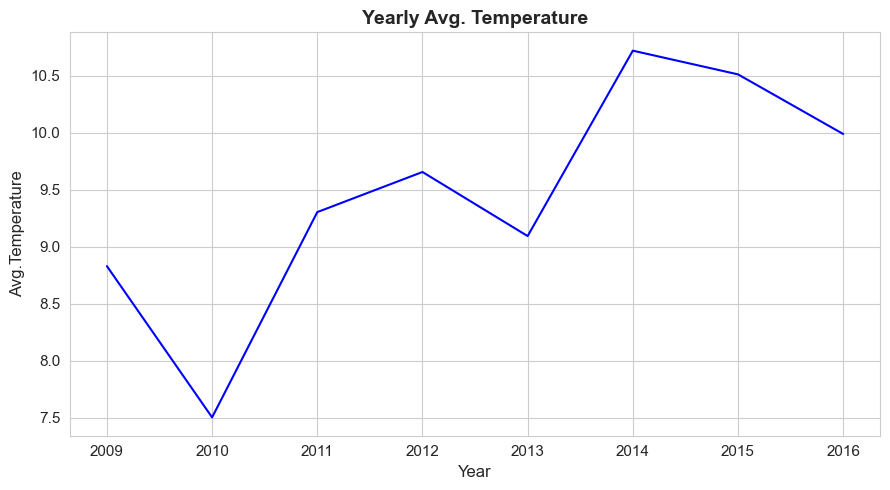

In [12]:
max_xtick = len(temp_year_df)
fig, ax = plt.subplots(figsize=(9,5))
p=sns.lineplot(x="year", y="T", data=temp_year_df , color='blue')
ax.set_ylabel('Avg.Temperature', size=12)
ax.set_xlabel('Year', size=12)
plt.xticks(fontsize=11, rotation=0)
plt.yticks(fontsize=11)
#ax.set_xticks(np.arange(0,max_xtick, 1))
plt.title("Yearly Avg. Temperature",  fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

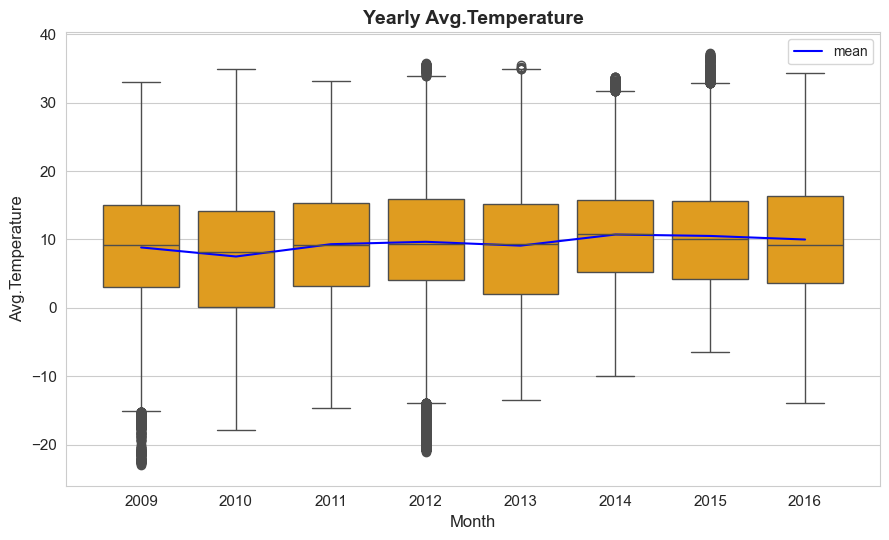

In [13]:
years = climate_df['year'].unique().to_numpy().flatten()
fig, axes = plt.subplots(figsize=(9,5.5))
ax = sns.boxplot(x="year", y="T", data=climate_df, showfliers=True, color='orange')
ax = sns.lineplot(x=range(0,len(years)), y=temp_year_df['T'], color='blue', label='mean')
ax.set_ylabel('Avg.Temperature', size=12)
ax.set_xlabel('Month', size=12)
plt.xticks(fontsize=11, rotation=0)
plt.yticks(fontsize=11)
plt.title(f"Yearly Avg.Temperature", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

### **Monthly temperature time series**

Now we compute the monthly temperature time series, grouping the temperature by year-month and aggregating by the mean.

In [14]:
temp_month_df = climate_df.group_by(['year', 'month']).agg(pl.col('T').mean()).sort(['year', 'month'])
temp_month_df = temp_month_df.with_columns((pl.col("month").cast(str) + '-' + pl.col("year").cast(str)).alias("month-year"))

In [15]:
temp_month_df.head()

shape: (5, 4)
┌──────┬───────┬───────────┬────────────┐
│ year ┆ month ┆ T         ┆ month-year │
│ ---  ┆ ---   ┆ ---       ┆ ---        │
│ i32  ┆ i8    ┆ f64       ┆ str        │
╞══════╪═══════╪═══════════╪════════════╡
│ 2009 ┆ 1     ┆ -3.626617 ┆ 1-2009     │
│ 2009 ┆ 2     ┆ 0.16995   ┆ 2-2009     │
│ 2009 ┆ 3     ┆ 3.989944  ┆ 3-2009     │
│ 2009 ┆ 4     ┆ 11.889757 ┆ 4-2009     │
│ 2009 ┆ 5     ┆ 13.433905 ┆ 5-2009     │
└──────┴───────┴───────────┴────────────┘

#### **Plotting**

We plot the this time series, first using a lineplot and secondly with a box plot for each month, overlapping the the mean for each one.

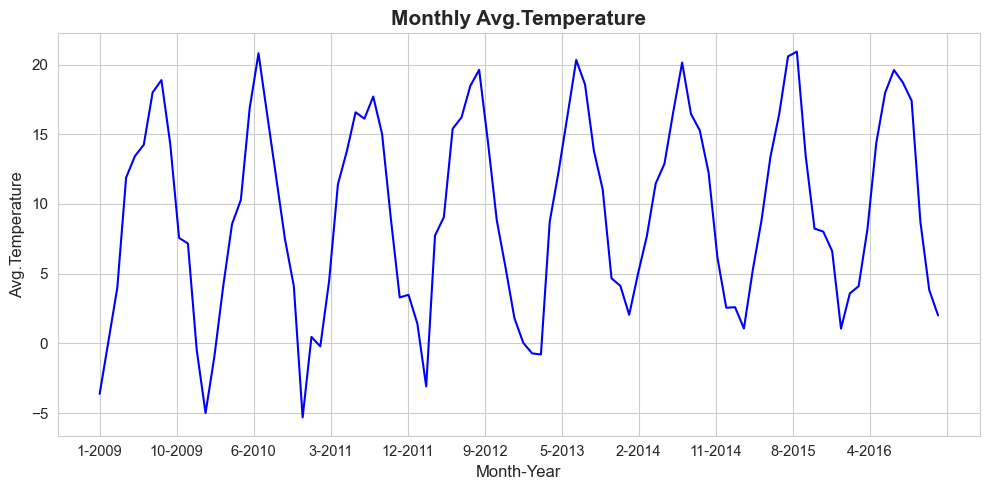

In [16]:
max_xtick = len(temp_month_df)
fig, ax = plt.subplots(figsize=(10,5))
p=sns.lineplot(x="month-year", y="T", data=temp_month_df , color='blue')
ax.set_ylabel('Avg.Temperature', size=12)
ax.set_xlabel('Month-Year', size=12)
plt.xticks(fontsize=10.5, rotation=0)
plt.yticks(fontsize=11)
ax.set_xticks(np.linspace(0, max_xtick, 12))
plt.title("Monthly Avg.Temperature", fontsize=15, weight='bold')
plt.tight_layout()
plt.show()

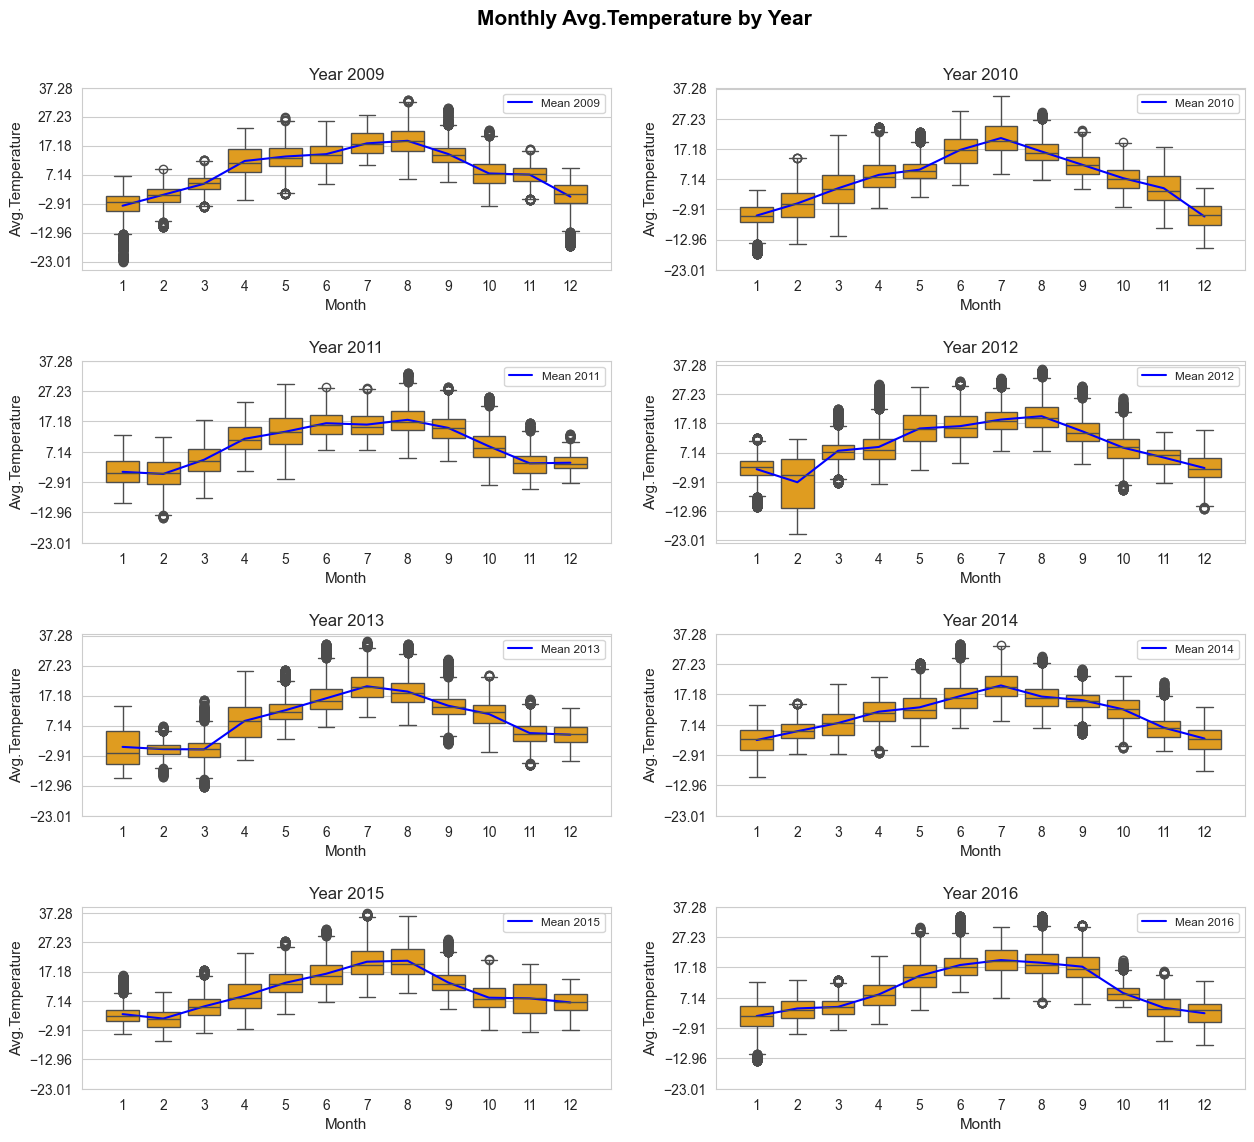

In [17]:
years = climate_df['year'].unique().to_numpy().flatten()
n_columns = 2
n_rows = int(np.ceil(len(years) / n_columns))
min_temp = climate_df['T'].min()
max_temp = climate_df['T'].max()
fig, axes = plt.subplots(n_rows, n_columns, figsize=(15, 13))
axes = axes.flatten()  
for i, year in enumerate(years):
    ax = sns.boxplot(x="month", y="T", data=climate_df.filter(pl.col('year') == year), 
                    showfliers=True, color='orange', ax=axes[i])
    ax = sns.lineplot(x=range(0,12), y=temp_month_df.filter(pl.col('year') == year)['T'], 
                    color='blue', ax=axes[i], label=f'Mean {year}')
    axes[i].legend(fontsize=8.5)
    axes[i].set_title(f'Year {year}', fontsize=12)
    axes[i].set_xlabel('Month', fontsize=11)
    axes[i].set_ylabel('Avg.Temperature', fontsize=11)
    axes[i].set_yticks(np.linspace(min_temp, max_temp, 7))
    plt.suptitle('Monthly Avg.Temperature by Year', 
                fontsize=15, y=0.94, weight='bold', color='black', alpha=1)
# Remove any unused subplots in case the number of 'geo' values is less than num_rows * num_cols
for j in range(len(years), n_rows * n_columns):
    fig.delaxes(axes[j])
plt.subplots_adjust(hspace=0.5, wspace=0.2) 
plt.show()

### **Daily time series**

In this section we are going to compute the daily time series for the temperature (`T`), humidity (`rh`) and wind speed (`wv`), which are the time series we are interested in forecasting.

In [18]:
df = {}
variables_to_forecast = ['T', 'rh', 'wv']
for col in variables_to_forecast:
    df[col] = climate_df.group_by(['year', 'month', 'day']).agg(pl.col(col).mean()).sort(['year', 'month', 'day'])
    df[col] = df[col].with_columns((pl.col("day").cast(str) + '-' + pl.col("month").cast(str) + '-' + pl.col("year").cast(str)).alias("date"))
    df[col] = df[col].with_columns(pl.col("date").str.to_date("%d-%m-%Y").name.keep())

In [19]:
for col in variables_to_forecast:
    display(df[col].head())

shape: (5, 5)
┌──────┬───────┬─────┬───────────┬────────────┐
│ year ┆ month ┆ day ┆ T         ┆ date       │
│ ---  ┆ ---   ┆ --- ┆ ---       ┆ ---        │
│ i32  ┆ i8    ┆ i8  ┆ f64       ┆ date       │
╞══════╪═══════╪═════╪═══════════╪════════════╡
│ 2009 ┆ 1     ┆ 1   ┆ -6.810629 ┆ 2009-01-01 │
│ 2009 ┆ 1     ┆ 2   ┆ -3.728194 ┆ 2009-01-02 │
│ 2009 ┆ 1     ┆ 3   ┆ -5.271736 ┆ 2009-01-03 │
│ 2009 ┆ 1     ┆ 4   ┆ -1.375208 ┆ 2009-01-04 │
│ 2009 ┆ 1     ┆ 5   ┆ -4.867153 ┆ 2009-01-05 │
└──────┴───────┴─────┴───────────┴────────────┘

shape: (5, 5)
┌──────┬───────┬─────┬───────────┬────────────┐
│ year ┆ month ┆ day ┆ rh        ┆ date       │
│ ---  ┆ ---   ┆ --- ┆ ---       ┆ ---        │
│ i32  ┆ i8    ┆ i8  ┆ f64       ┆ date       │
╞══════╪═══════╪═════╪═══════════╪════════════╡
│ 2009 ┆ 1     ┆ 1   ┆ 91.086014 ┆ 2009-01-01 │
│ 2009 ┆ 1     ┆ 2   ┆ 92.086806 ┆ 2009-01-02 │
│ 2009 ┆ 1     ┆ 3   ┆ 76.458056 ┆ 2009-01-03 │
│ 2009 ┆ 1     ┆ 4   ┆ 89.417361 ┆ 2009-01-04 │
│ 2009 ┆ 1     ┆ 5   ┆ 86.260417 ┆ 2009-01-05 │
└──────┴───────┴─────┴───────────┴────────────┘

shape: (5, 5)
┌──────┬───────┬─────┬──────────┬────────────┐
│ year ┆ month ┆ day ┆ wv       ┆ date       │
│ ---  ┆ ---   ┆ --- ┆ ---      ┆ ---        │
│ i32  ┆ i8    ┆ i8  ┆ f64      ┆ date       │
╞══════╪═══════╪═════╪══════════╪════════════╡
│ 2009 ┆ 1     ┆ 1   ┆ 0.778601 ┆ 2009-01-01 │
│ 2009 ┆ 1     ┆ 2   ┆ 1.419514 ┆ 2009-01-02 │
│ 2009 ┆ 1     ┆ 3   ┆ 1.250903 ┆ 2009-01-03 │
│ 2009 ┆ 1     ┆ 4   ┆ 1.720417 ┆ 2009-01-04 │
│ 2009 ┆ 1     ┆ 5   ┆ 3.800278 ┆ 2009-01-05 │
└──────┴───────┴─────┴──────────┴────────────┘

#### **Plotting**

We plot the three time series using a lineplot.

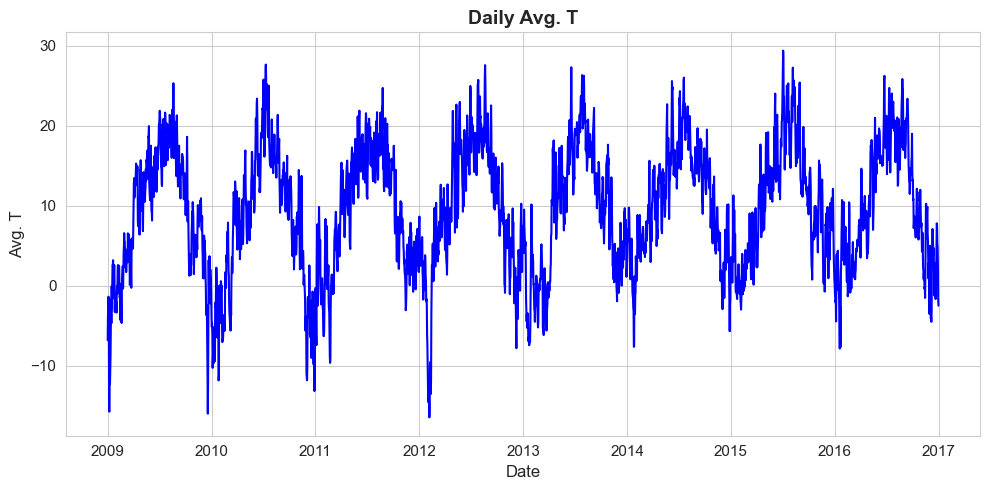

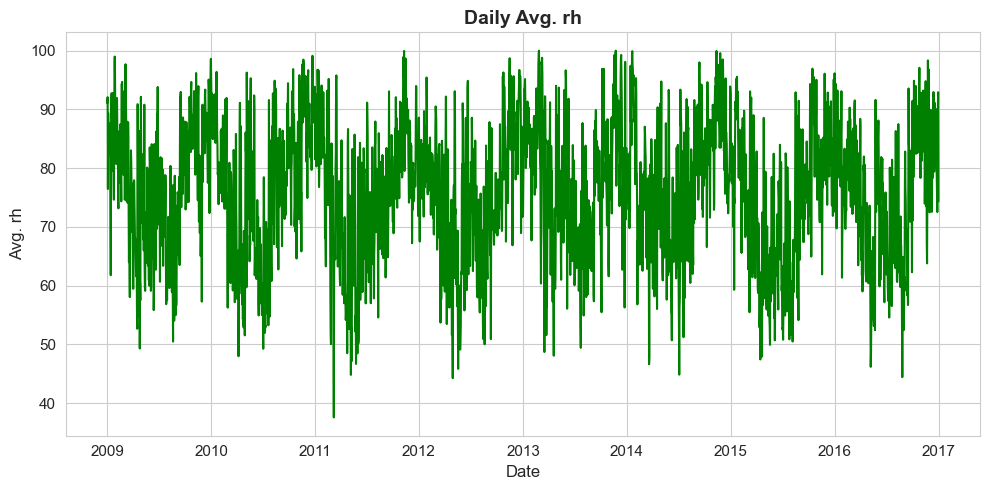

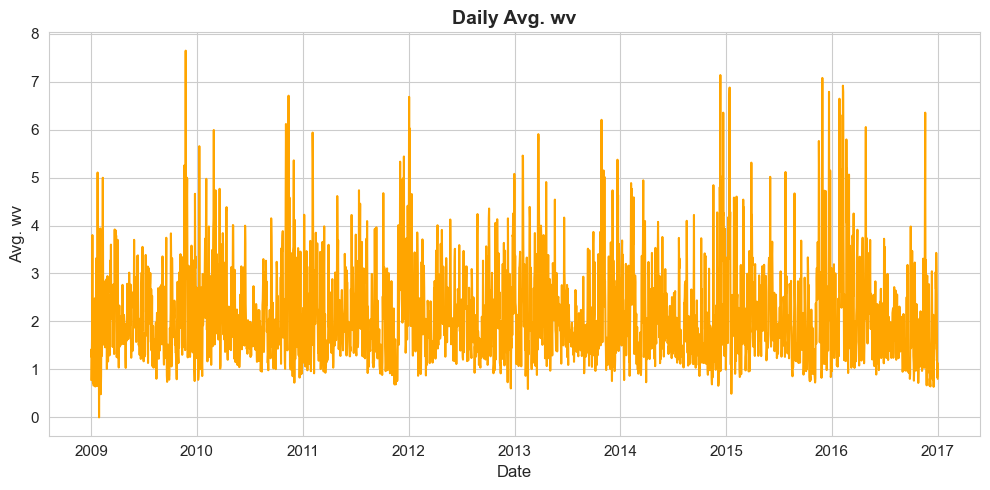

In [20]:
colors = ['blue', 'green', 'orange']
for i, col in enumerate(variables_to_forecast):

    max_xtick = len(df[col])
    fig, ax = plt.subplots(figsize=(10,5))
    p=sns.lineplot(x="date", y=col, data=df[col] , color=colors[i])
    ax.set_ylabel(f'Avg. {col}', size=12)
    ax.set_xlabel('Date', size=12)
    plt.xticks(fontsize=11, rotation=0)
    plt.yticks(fontsize=11)
    #ax.set_xticks(np.linspace(0, max_xtick, 12))
    plt.title(f"Daily Avg. {col}", fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()

We can plot boxplots for the daily temperature in a given month of a given year, in this case we will plot january, july and october of 2016 (the last year available in the data).

- Without the same y-axes scale for each row

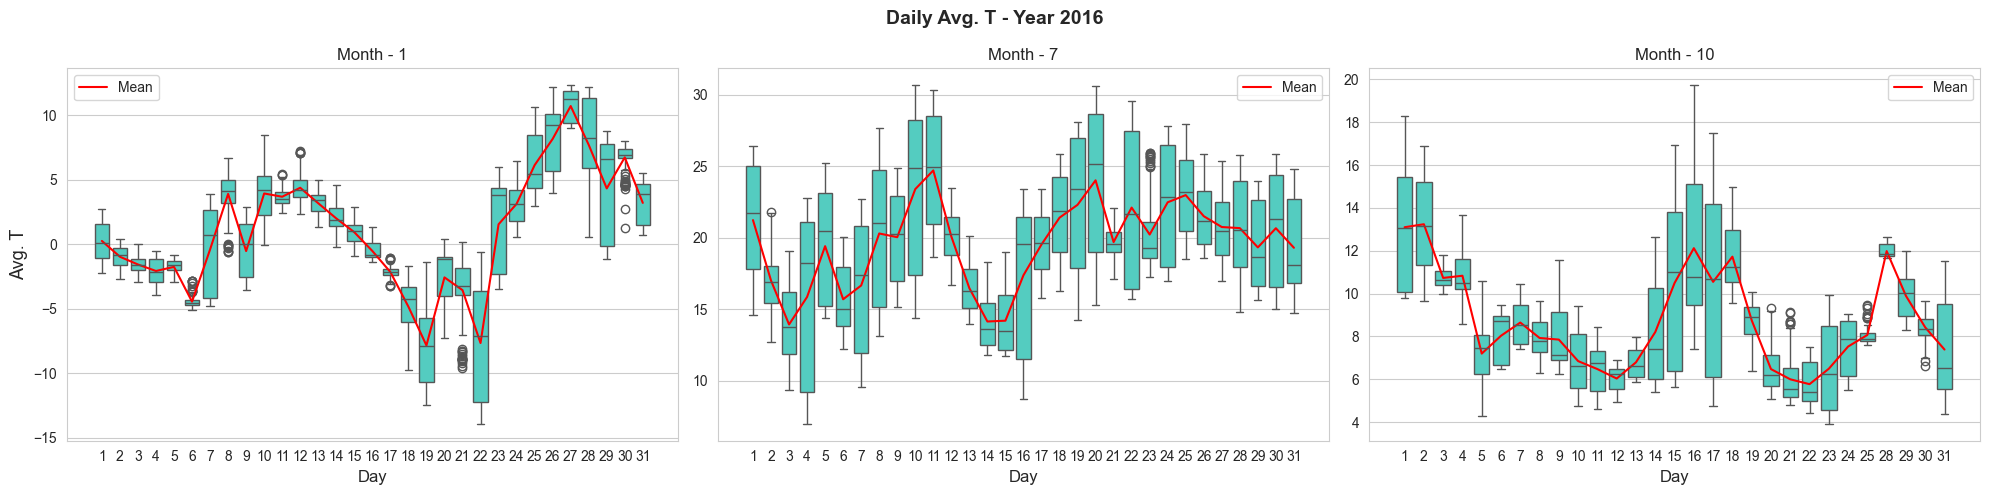

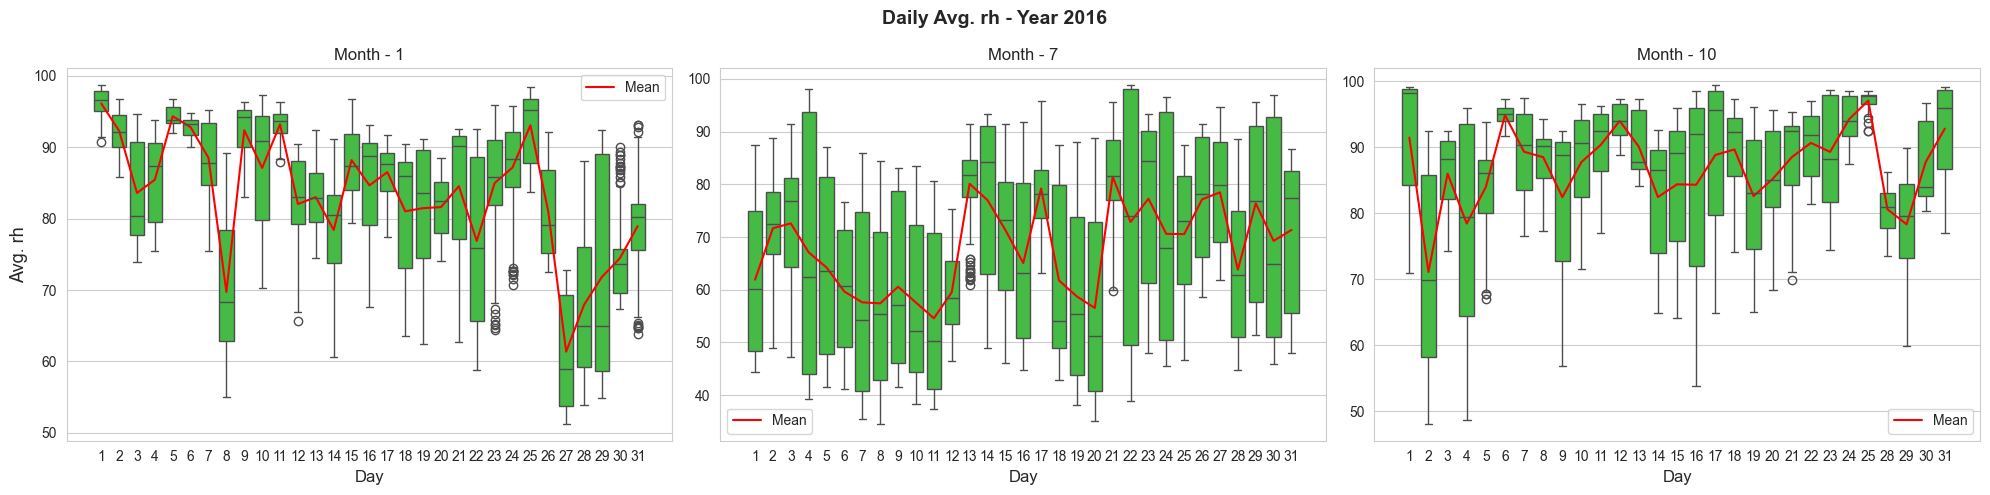

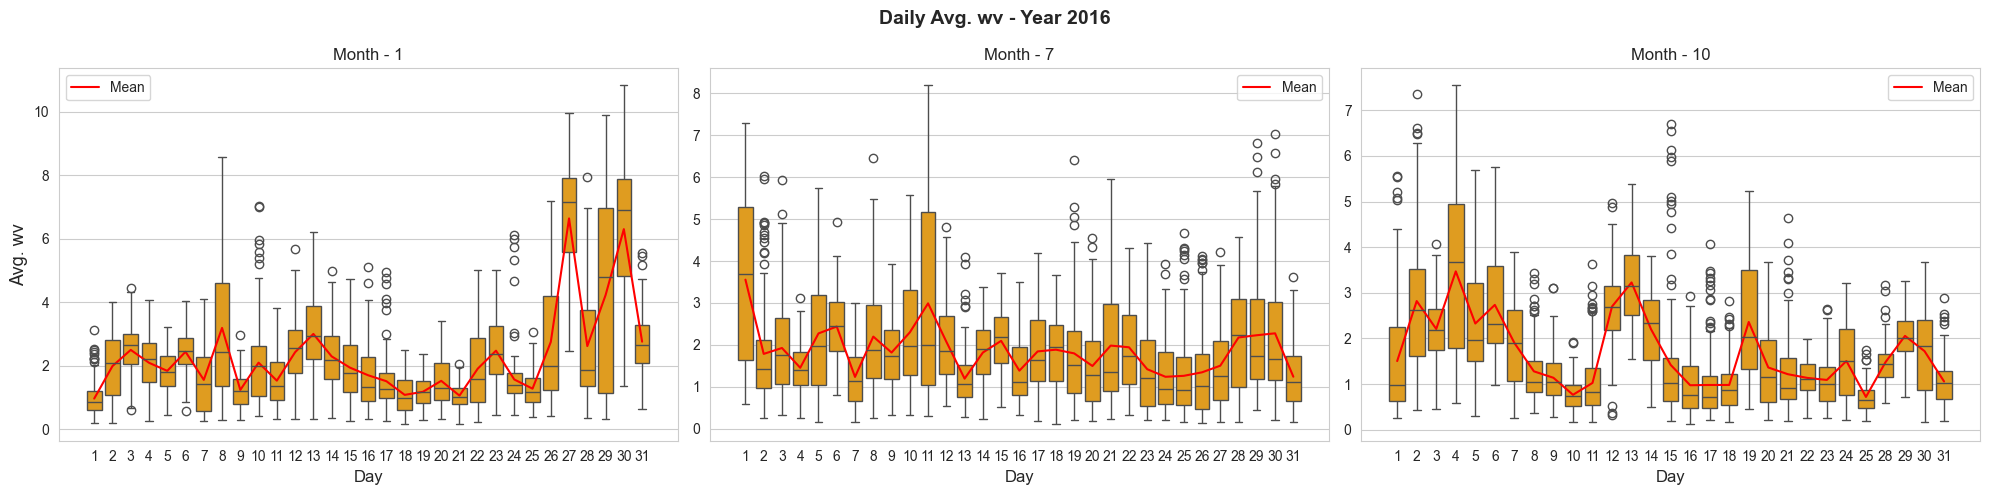

In [21]:
year = 2016
colors = ['turquoise', 'limegreen', 'orange']

for i, col in enumerate(variables_to_forecast):

    fig, axes = plt.subplots(1,3, figsize=(20,5))
    axes = axes.flatten()

    for r, month in enumerate([1, 7, 10]):

        n_months = len(df[col].filter(pl.col('year') == year, pl.col('month') == month))
        ax = sns.boxplot(x="day", y=col, data=climate_df.filter(pl.col('year') == year, pl.col('month') == month), showfliers=True, color=colors[i], ax=axes[r])
        ax = sns.lineplot(x=range(0,n_months), y=df[col].filter(pl.col('year') == year, pl.col('month') == month)[col], color='red', label='Mean', ax=axes[r])
        axes[r].set_xlabel('Day', size=12)
        axes[r].set_ylabel('', size=13)
        axes[r].set_title(f'Month - {month}', fontsize=12)
        axes[r].tick_params(axis='x', rotation=0, labelsize=10)
    axes[0].set_ylabel(f'Avg. {col}', size=13)

    plt.suptitle(f"Daily Avg. {col} - Year {year}",  fontsize = 14, weight='bold')
    plt.tight_layout()
    plt.show()

- Using the same y-axes scale for each row

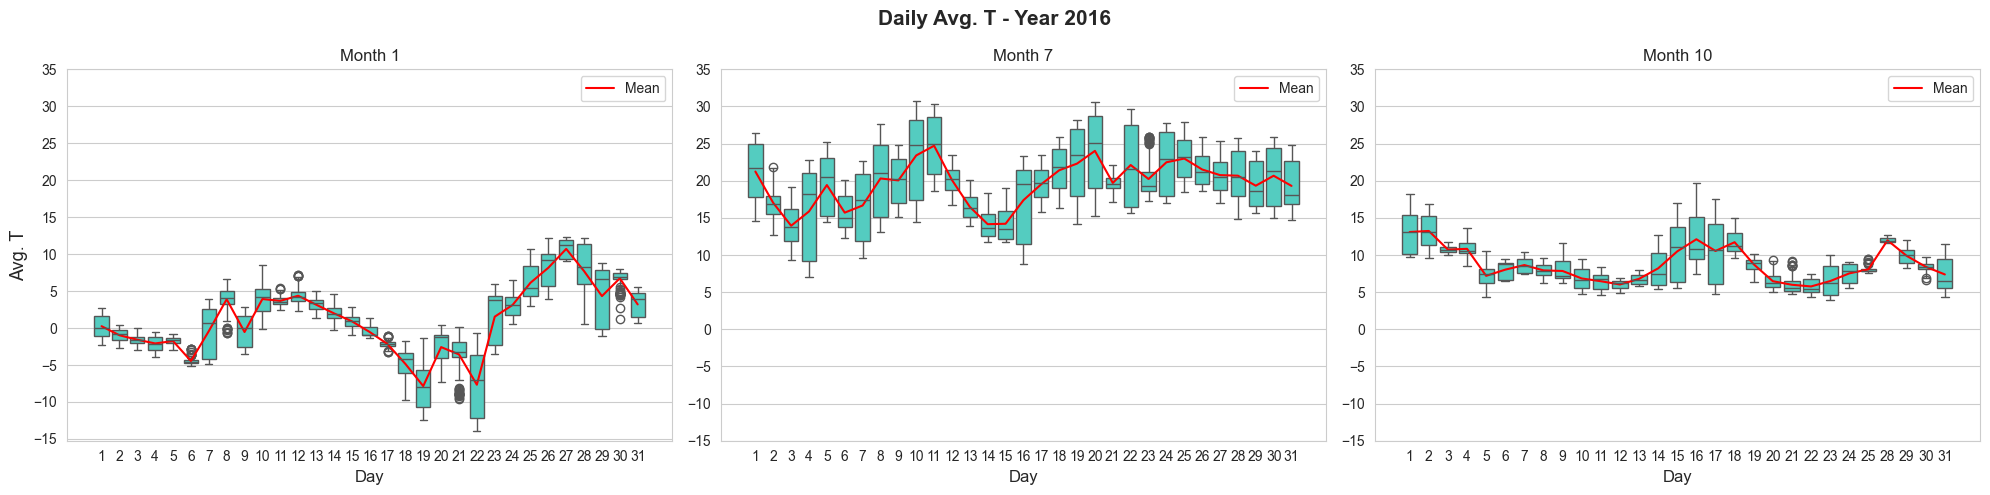

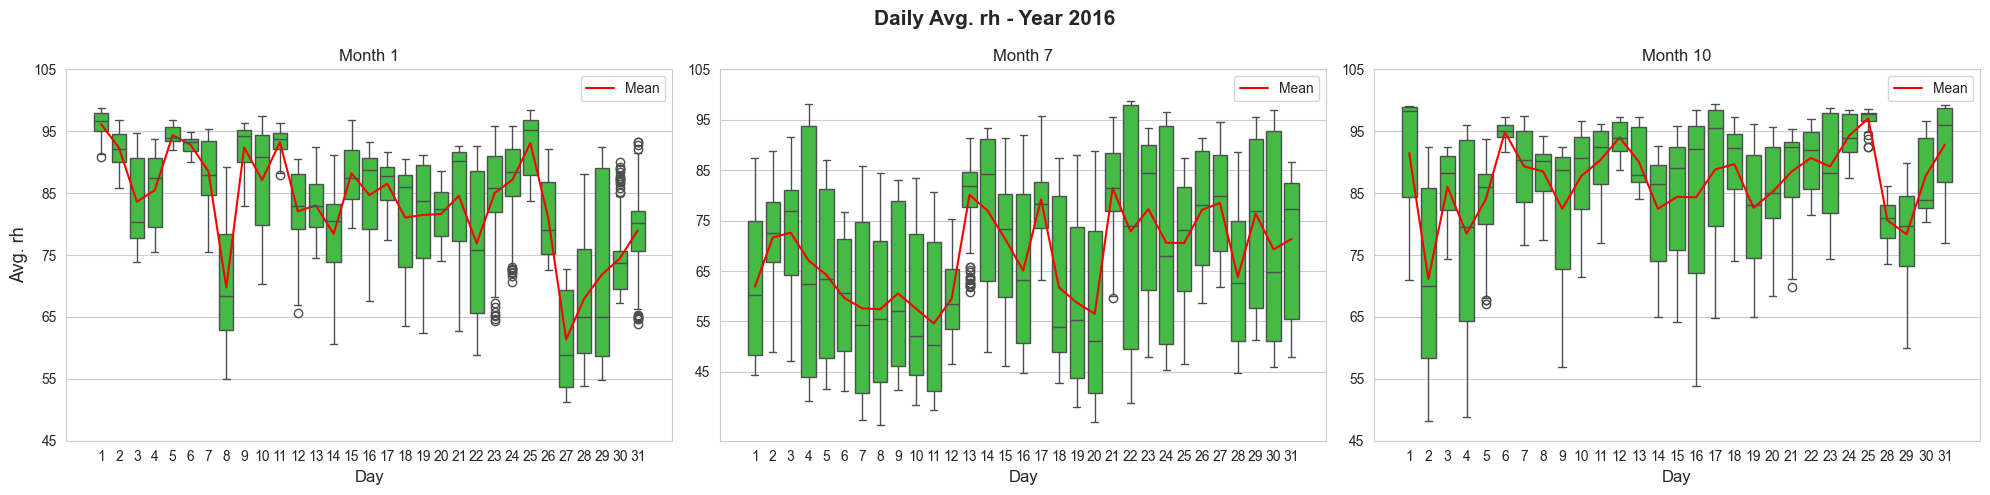

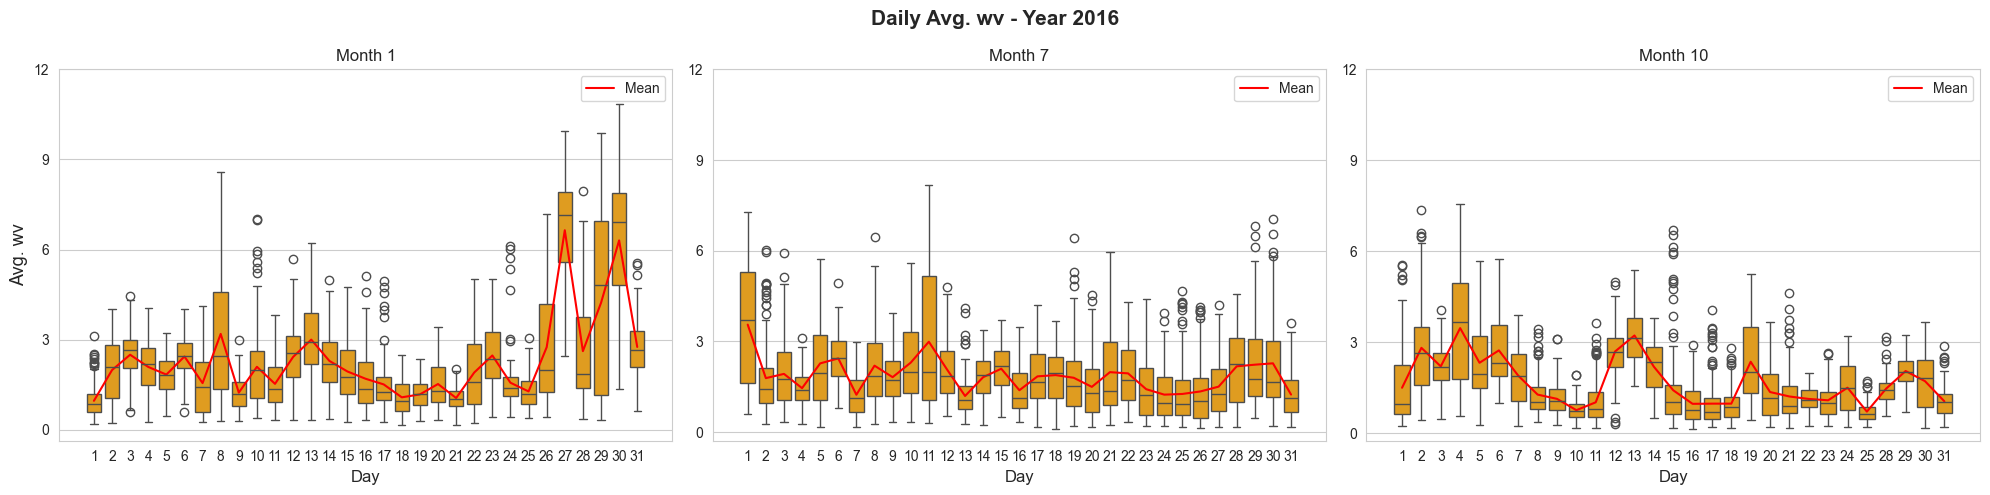

In [22]:
yticks = [np.arange(-15,37, 5), np.arange(45,115, 10), np.arange(0,15, 3)]

for i, col in enumerate(variables_to_forecast):

    fig, axes = plt.subplots(1,3, figsize=(20,5))
    axes = axes.flatten()

    for r, month in enumerate([1, 7, 10]):

        n_months = len(df[col].filter(pl.col('year') == year, pl.col('month') == month))
        ax = sns.boxplot(x="day", y=col, data=climate_df.filter(pl.col('year') == year, pl.col('month') == month), showfliers=True, color=colors[i], ax=axes[r])
        ax = sns.lineplot(x=range(0,n_months), y=df[col].filter(pl.col('year') == year, pl.col('month') == month)[col], color='red', label='Mean', ax=axes[r])
        axes[r].set_xlabel('Day', size=12)
        axes[r].set_ylabel('', size=13)
        axes[r].set_title(f'Month {month}', fontsize=12)
        axes[r].tick_params(axis='x', rotation=0, labelsize=10)
        axes[r].set_yticks(yticks[i])
    axes[0].set_ylabel(f'Avg. {col}', size=13)

    plt.suptitle(f"Daily Avg. {col} - Year {year}",  fontsize = 15, weight='bold')
    plt.tight_layout()
    plt.show()

## **Forecasting Daily Temperature, Humidity and Wind Speed**

In this section we are going to look for the best models for forecasting the daily temperature, humidity and wind speed, following an statistical approach, this means that we are not going to use more Machine Learning related tools like full automatic grid search algorithms and other ML algorithms (this will be done in the second project), and we will be also specially focus in SARIMA models, and will characterize them based on statistical techniques such as time series decomposition, correlation plots and the Dickey Fuller test.

It's important to notice that our main goal is to find three models for forecasting the temperature, humidity and wind speed ***15*** days in advanced.

We say three models because we are going to loo for the best model for forecasting each variable, but the same model could be the best for several of the variables.

Anyway, the main aim of the project is look for a good model but, as we commented before, without using exhaustive ML search algorithms, because this will be done in the next project. this project is more manual and statistical oriented.

### **Response and Predictors (lags)**

In time series we can use the lags of the response variable to predict it, namely, for a given date, we can use the past values of the response with respect of that date to predict it for that specific date. These past values are called lags, and the number of lags considered is a really important hyper-parameter in time series.

So, in time series the lags of the response play the role of predictors, even though they could not be the only predictors since other external variables could be used in the forecasting process, this is what we called multivariate time series, and it will be addressed in the second project.

The nex code define the response for each problem (temperature, humidity and wind speed forecasting), then, a fake predictors matrix is create for our `statsmodels` based implementations (them require that, but is only a technical detail related with how they are been characterize from a programming perspective). Afert that the code define the predictors and response for our `sklearn`based implementations, which must incorporate the lags. In this case we have add a grid of lags, because, as we said before, they are an important hyper-parameter.

It's important to notice that `statsmodels` based implementations only need the original response, without lags, and a predictors matrix is not required, beyond the fake one, that is, in fact, a zero matrix, which is not used by the model at all.

In [23]:
Y, X_st = {}, {}
X_sk, Y_sk, make_lags = {col: {} for col in variables_to_forecast}, {col: {} for col in variables_to_forecast}, {col: {} for col in variables_to_forecast}
lags_grid = [1, 2, 3, 7, 10, 20, 30, 40]

for col in variables_to_forecast:

    Y[col] = df[col][col].to_numpy()

    # Fake X for statsmodels based implementations
    X_st[col] = np.zeros((len(Y[col]), 4))
                         
    # Lagged X and Y for sklearn based implementations
    for lag in lags_grid:
        make_lags[col][lag] = MakeLags(n_lags=lag, ascending=True)
        make_lags[col][lag].fit()
        X_sk[col][lag], Y_sk[col][lag] = make_lags[col][lag].transform(y=Y[col])

For a better understanding we are going to display the 3-lagged response and predictors, for the temperature, gathered in a single data-frame:

In [24]:
make_lags['T'][3].y_lags_df.head(7)

shape: (7, 4)
┌────────────┬────────────┬───────────┬───────────┐
│ Y          ┆ Y_lag_1    ┆ Y_lag_2   ┆ Y_lag_3   │
│ ---        ┆ ---        ┆ ---       ┆ ---       │
│ f64        ┆ f64        ┆ f64       ┆ f64       │
╞════════════╪════════════╪═══════════╪═══════════╡
│ -6.810629  ┆ NaN        ┆ NaN       ┆ NaN       │
│ -3.728194  ┆ -6.810629  ┆ NaN       ┆ NaN       │
│ -5.271736  ┆ -3.728194  ┆ -6.810629 ┆ NaN       │
│ -1.375208  ┆ -5.271736  ┆ -3.728194 ┆ -6.810629 │
│ -4.867153  ┆ -1.375208  ┆ -5.271736 ┆ -3.728194 │
│ -15.482847 ┆ -4.867153  ┆ -1.375208 ┆ -5.271736 │
│ -15.734375 ┆ -15.482847 ┆ -4.867153 ┆ -1.375208 │
└────────────┴────────────┴───────────┴───────────┘

The rows with `NaN` will not be used for training the models. The fourth row is the fist without `NaN`, the first column contains the original values of the response, the other columns contain the lagged response in different orders. Specifically, the second column contains the response lagged 1 period (day), the third lagged 2 days and the fourth lagged 3 days.

So, given a row without `NaN`, the value of the first column represents the actual value of the response (temperature in this case) in a given day, and the values of the resting columns represent the temperature in the previous three days (since there are 3 lags).

The idea is to use models that learn the relationship between the temperature in a given day an the one in the previous three days, and this for all the available days in a given training set.

In [25]:
Y_sk['T'][3]

array([ -1.37520833,  -4.86715278, -15.48284722, ...,   2.67625   ,
        -1.70659722,  -2.4925    ])

In [26]:
X_sk['T'][3]

array([[-5.27173611, -3.72819444, -6.81062937],
       [-1.37520833, -5.27173611, -3.72819444],
       [-4.86715278, -1.37520833, -5.27173611],
       ...,
       [ 4.88715278,  5.245625  ,  7.52743056],
       [ 2.67625   ,  4.88715278,  5.245625  ],
       [-1.70659722,  2.67625   ,  4.88715278]])

### **Characterizing SARIMA models**

#### **Time series decomposition**

In [27]:
decomposition = {}
for col in variables_to_forecast:
    decomposition[col] = STL(Y[col], period=7).fit()

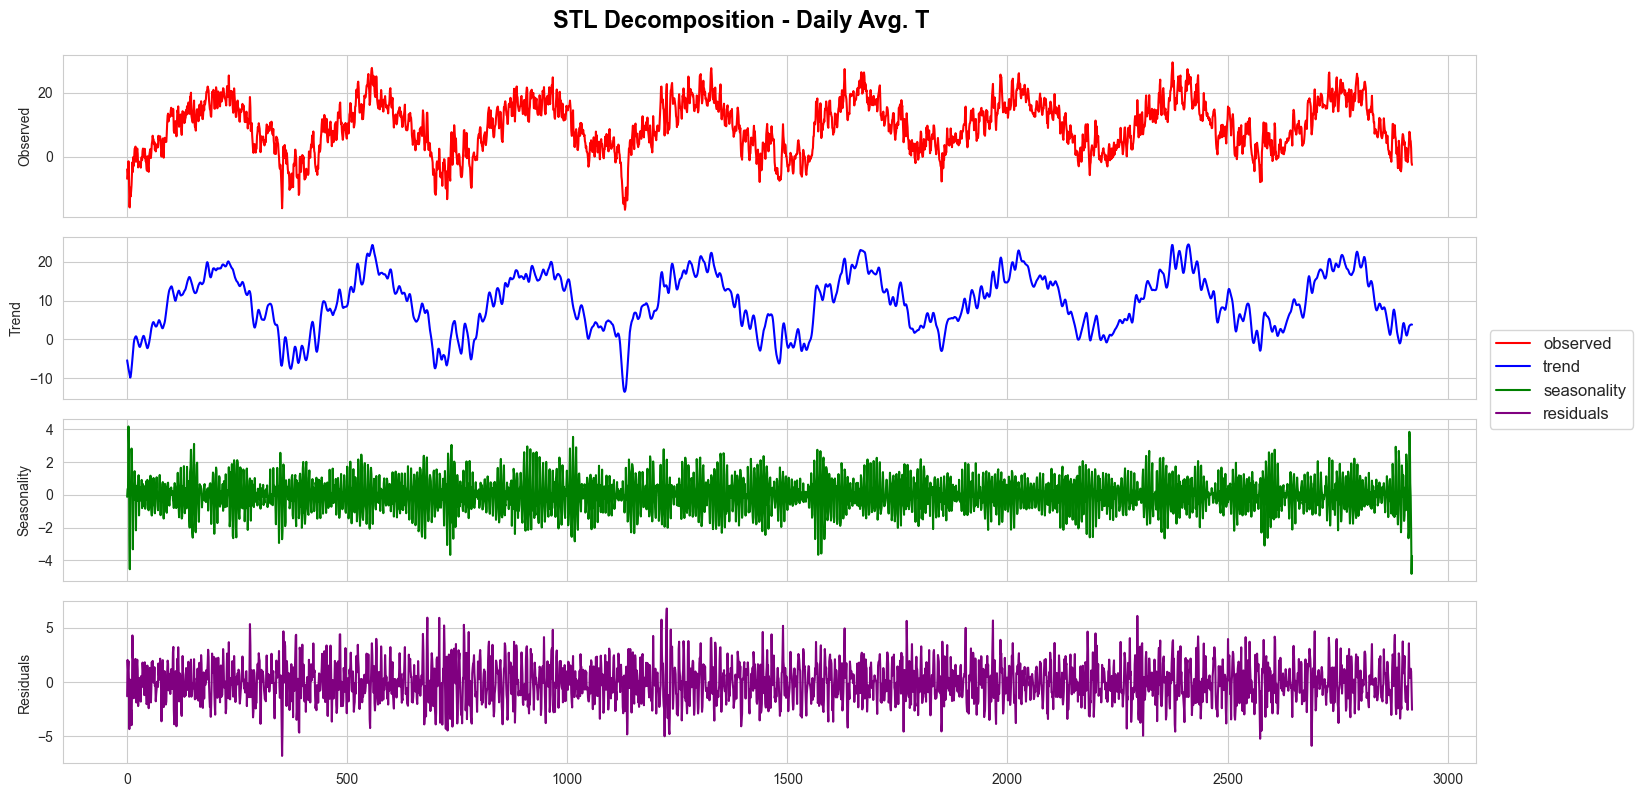

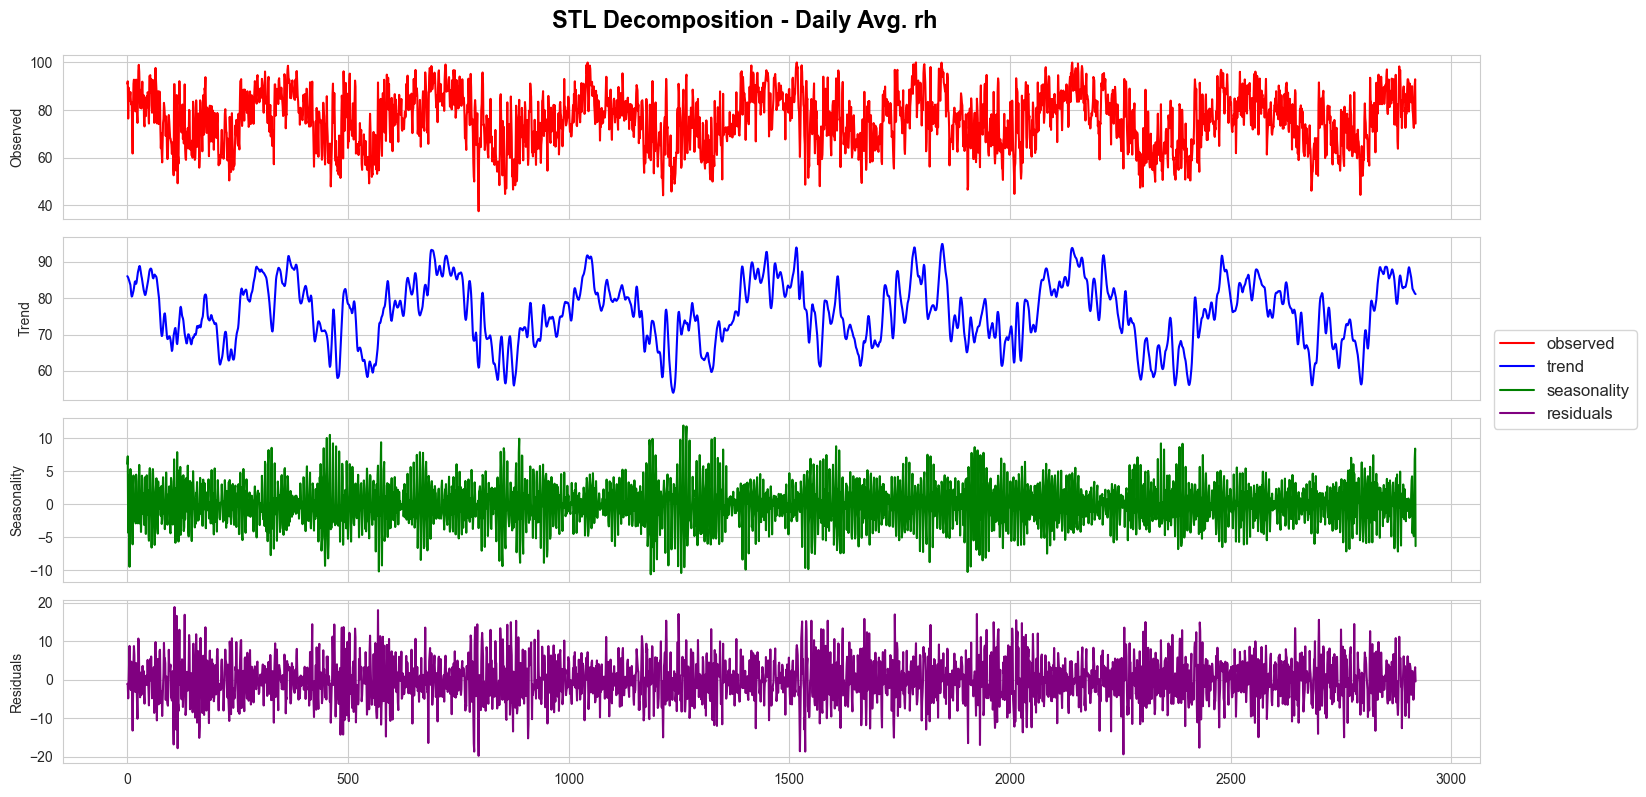

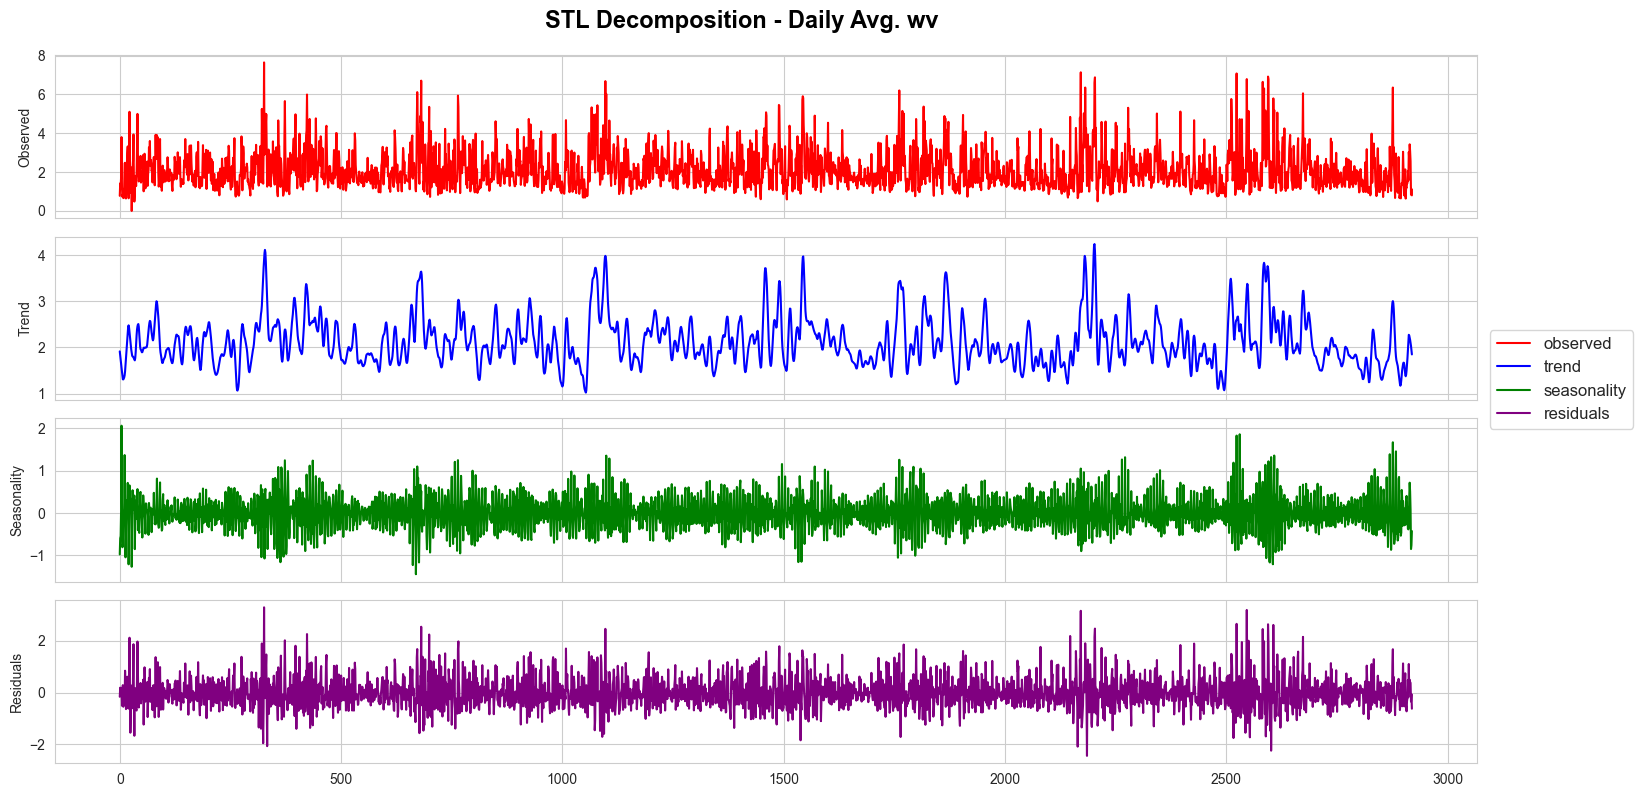

In [28]:
for col in variables_to_forecast:

    fig, axs = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(15,8))
    p1=sns.lineplot(decomposition[col].observed, color='red', ax=axs[0], label='observed')
    p2=sns.lineplot(decomposition[col].trend, color='blue', ax=axs[1], label='trend')
    p3=sns.lineplot(decomposition[col].seasonal, color='green', ax=axs[2], label='seasonality')
    p4=sns.lineplot(decomposition[col].resid, color='purple', ax=axs[3], label='residuals')
    p1.set_ylabel('Observed')
    p2.set_ylabel('Trend')
    p3.set_ylabel('Seasonality')
    p4.set_ylabel('Residuals')
    plt.suptitle(f'STL Decomposition - Daily Avg. {col}', 
                fontsize=17, y=0.99, weight='bold', color='black')
    plt.tight_layout()

    # Remove individual legends created by seaborn lineplot
    for ax in axs:
        ax.get_legend().remove()

    # Create a common legend for the figure
    handles, labels = [], []
    for ax in axs:
        for handle, label in zip(*ax.get_legend_handles_labels()):
            handles.append(handle)
            labels.append(label)

    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 0.6), fontsize=12)

    plt.show()

According to these plots and the ones showed before, we can extract some information regarding the trend and seasonality components of our three series in discussion.

- **Temperature** (`T`): 

    - **Trend** component: it seems that the daily temperature has non trend, since the values oscillate around a same point along the series, in other words, it has an approximately constant mean along the time. This fact tell us that a difference in the regular part will not be necessary, but, despite the plots, the will carry out an statistical test for checking this point later, the (augmented) Dickey Fuller test.

    - **Seasonal** component: the series has a clear seasonality, which is clearly shown in the plots, and, moreover, we know that temperature is directly related to the seasons, so in this case there is no doubt. So, it seems that the series needs a difference en the seasonal part, to make it stationary in that component. The seasonality period seems to be 365 days, since the seasonal pattern seems to be repeated each 365 days.

- **Humidity** (`rh`):

    - **Trend** component: it seems that the daily relative humidity has non trend, since the values oscillate around a same point along the series, in other words, it has an approximately constant mean along the time. This fact tell us that a difference in the regular part would not be necessary.

    - **Seasonal** component: the series has a clear seasonality (although not as clear as in the temperature case), which is shown in the plots. So, it seems that the series needs a difference en the seasonal part, to make it stationary in that component. The seasonality period seems to be 365 days, since the seasonal pattern seems to be repeated each 365 days.

- **Wind speed** (`wv`):

    - **Trend** component: it seems that the daily wind speed has non trend, since the values oscillate around a same point along the series, in other words, it has an approximately constant mean along the time. This fact tell us that a difference in the regular part would not be necessary.

    - **Seasonal** component: the series has a non clear seasonality, so it seems that the series doesn't need a difference in the seasonal part. Moreover, the seasonal part of the SARIMA model wouldn't be necessary.




So according to the previous analysis, the suggested difference parameters for a SARIMA model would be:
    
- **Temperature** (`T`):
  
   - $d = 0\quad$ (regular difference)
   
   - $D=1, 2\quad$ (seasonal difference)

   - $s=365$

-  **Humidity** (`rh`):

   - $d = 0$
   
   - $D=1, 2$

   - $s=365$

- **Wind speed** (`wv`):

   - $d=0$

   - $D=0$

   - $s=0$

   - $P,Q=0$

As we will see later, $s=365$ involves a lot of computational time with our data and the current implementation of the SARIMA model by `statsmodels`. Due to that we will have to set a much lower different values,  just to train the models in a reasonable time, even though we known that those values of $s$ will not be the most suitable at all from a theoretical perspective, but are much more efficient computationally.

#### **Auto-correlation Plots**

##### **Regular part $(p,q)$**

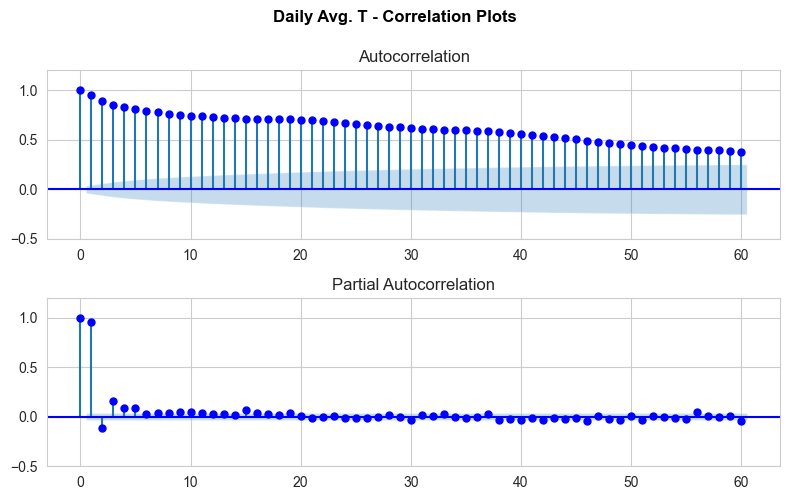

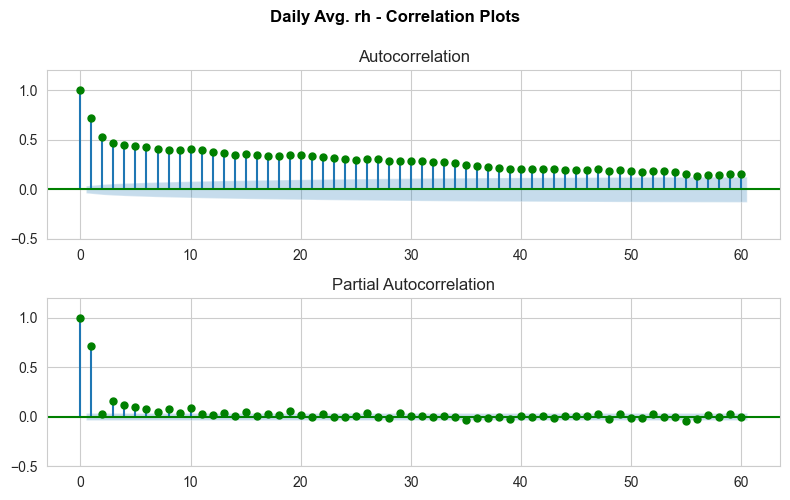

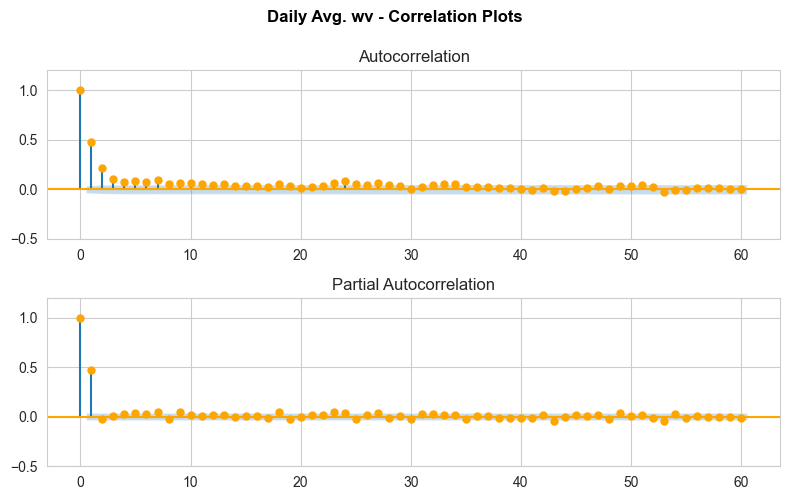

In [29]:
colors = ['blue', 'green', 'orange']

for i, col in enumerate(variables_to_forecast):

    fig, ax = plt.subplots(2, 1, figsize=(8, 5))
    plot_acf(Y[col], lags=60, ax=ax[0], color=colors[i])
    plot_pacf(Y[col], lags=60, ax=ax[1], color=colors[i])
    ax[0].set_ylim(-0.5, 1.2) 
    ax[1].set_ylim(-0.5, 1.2) 
    plt.suptitle(f'Daily Avg. {col} - Correlation Plots', 
                fontsize=12, y=0.99, weight='bold', color='black')
    plt.tight_layout()
    plt.show()

According to these correlation plots we can guess the parameters $p$ and $q$ of the SARIMA model. 

- **Temperature** (`T`): 

    - **ACP:** the ACP shows a clear (maybe geometric) descending structure, which is common in a AR (auto-regressive) process.

    - **PACP:** the PACP shows that the first two partial-auto-correlations are non-zero significative while the rest not.

    - **Conclusion:** tis series fits with an AR process of order two $\Rightarrow p=2$ , $q=0$.

- **Humidity** (`rh`):

    - **ACP:** the ACP shows a clear (geometric) descending structure, which is common in a AR (auto-regressive) process.

    - **PACP:** the PACP shows that the first two partial auto correlations are non-zero significative while the rest not. But the second value is less significant than in the temperature series.

    - **Conclusion:** tis series fits with an AR process of order two, but it may also be of order one $\Rightarrow p=1,2$ , $q=0$.
    
- **Wind speed** (`wv`):

    - **ACP:** the ACP shows a very fast (geometric) descending structure, which is common in AR processes.

    - **PACP:** the PACP shows that the first partial auto correlations is non-zero significative while the rest not (although the second one could be significative as well).
    - **Conclusion:** tis series fits with an AR process of order two, but it may also be of order one $\Rightarrow p=1,2$ , $q=0$.


##### **Seasonal part $(P,Q)$**

We are going to apply a seasonal difference to the variables which show a seasonal component, namely, temperature and humidity, as we discussed before.

After that, we will plot the auto correlation plots for both, in order to identify or guess values for the parameters $P$ and $Q$, the order of the AR and MA processes in the seasonal part of  the SARIMA model.

In [30]:
Y_seasonal_diff = {}
variables_with_seasonality = ['T', 'rh']
for col in variables_with_seasonality:
    Y_seasonal_diff[col] = pd.DataFrame(Y[col]).diff(periods=365).dropna().to_numpy()

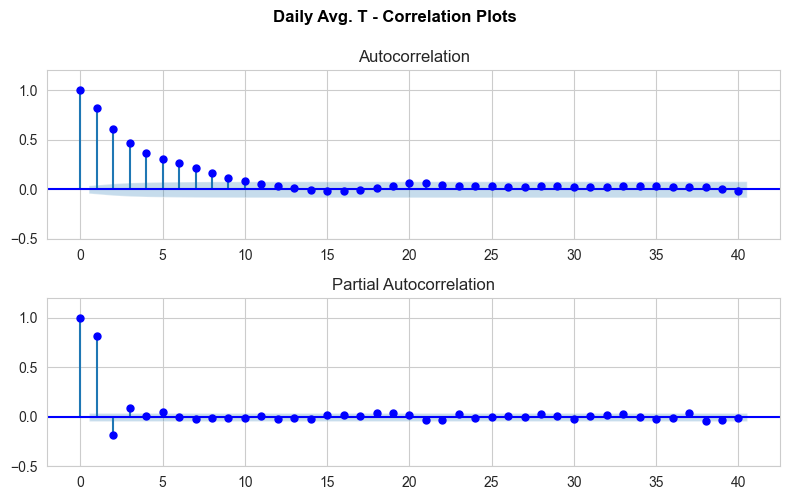

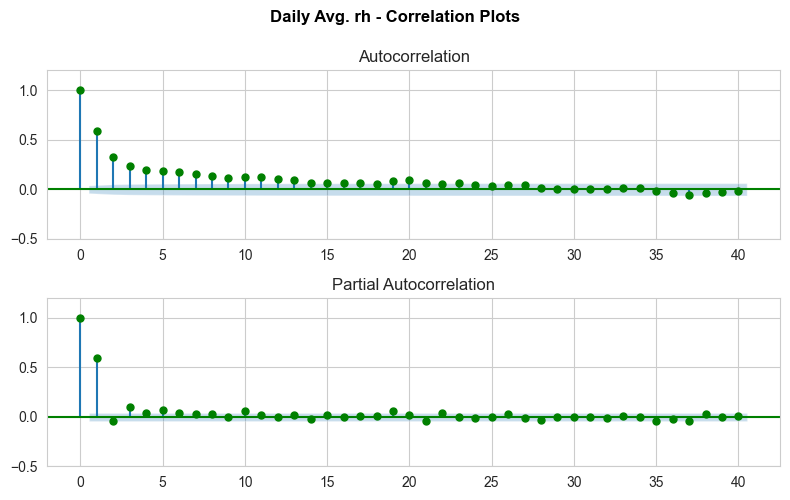

In [31]:
for i, col in enumerate(variables_with_seasonality):

    fig, ax = plt.subplots(2, 1, figsize=(8, 5))
    plot_acf(Y_seasonal_diff[col], lags=40, ax=ax[0], color=colors[i])
    plot_pacf(Y_seasonal_diff[col], lags=40, ax=ax[1], color=colors[i])
    ax[0].set_ylim(-0.5, 1.2) 
    ax[1].set_ylim(-0.5, 1.2) 
    plt.suptitle(f'Daily Avg. {col} - Correlation Plots', 
                fontsize=12, y=0.99, weight='bold', color='black')
    plt.tight_layout()
    plt.show()

According to these correlation plots we can guess the parameters $P$ and $Q$ of the SARIMA model. 

- **Temperature** (`T`): 

    - **ACP:** the ACP shows a clear (maybe geometric) descending structure, which is common in a AR (auto-regressive) process.

    - **PACP:** the PACP shows that the first two partial-auto-correlations are non-zero significative while the rest not, although it could be interpreted as well that only the first one is clearly significative.

    - **Conclusion:** this series fits with an AR process of order one or two in the seasonal part $\Rightarrow P=1,2$ , $Q=0$.

- **Humidity** (`rh`):

    - **ACP:** the ACP shows a clear (geometric) descending structure, which is common in a AR (auto-regressive) process.

    - **PACP:** the PACP shows that the first partial auto correlation is non-zero significative while the rest not. Although the second one could be considered as significative as well.

    - **Conclusion:** this series fits with an AR process of order one or two $\Rightarrow P=1,2$ , $Q=0$.

- **Wind speed** (`wv`):

   - As we saw before, the daily wind speed has not clear seasonality, so that $P=Q=0$.

#### **Augmented Dickey Fuller Test**

In this section we are going to carry out the augmented dickey fuller test for the three original series. This test has as null hypothesis $(H_0)$ that the series has non significative trend, so, is likely stationary in the regular part, and as alternative hypothesis the opposite. So, reject $H_0$ means that our series has significative trend and, therefore, needs (at least) one regular difference. And not reject $H_0$ means that our series is stationary in mean, that is, it doesn't show a clear trend, so, a difference in the regular part will not be needed.

In [32]:
print('------------------------------------------------------------------------------------------------------------------------------------------------')

for col in variables_to_forecast:

    result = adfuller(Y[col])
    test_statistic = np.round(result[0],3)
    p_value = np.round(result[1],3)

    print(f'Test Statistic the time series {col}: {test_statistic}')
    print(f'p-value for the time series {col}: {p_value}')

    alpha = 0.05
    if p_value < alpha:
        print(f'Reject the H0 --> The time series {col} seems stationary (non significative trend) --> The series doesn\'t need a regular difference')
    else:
        print(f'Not reject H0 --> The time series {col} seems non-stationary (significative trend)  --> The series needs a regular difference')

    print('------------------------------------------------------------------------------------------------------------------------------------------------')

------------------------------------------------------------------------------------------------------------------------------------------------
Test Statistic the time series T: -3.614
p-value for the time series T: 0.005
Reject the H0 --> The time series T seems stationary (non significative trend) --> The series doesn't need a regular difference
------------------------------------------------------------------------------------------------------------------------------------------------


Test Statistic the time series rh: -5.619
p-value for the time series rh: 0.0
Reject the H0 --> The time series rh seems stationary (non significative trend) --> The series doesn't need a regular difference
------------------------------------------------------------------------------------------------------------------------------------------------
Test Statistic the time series wv: -14.456
p-value for the time series wv: 0.0
Reject the H0 --> The time series wv seems stationary (non significative trend) --> The series doesn't need a regular difference
------------------------------------------------------------------------------------------------------------------------------------------------


As we deduced before, the three series has non significative trend, so a regular difference is not needed for them $(d=0)$.

#### **Final specification**

So, summarizing these are the suggested SARIMA models for each time series, according to the previous analysis:

- **Temperature** (`T`): $\quad(p=2, d=0, q=0)\times (P=1,2 , D=1,2, Q=0)_{s=365}$


- **Humidity** (`rh`): $\quad (p=1,2, d=0, q=0)\times (P=1,2 , D=1,2, Q=0)_{s=365}$


- **Wind speed** (`wv`): $\quad (p=1,2, d=0, q=0)\times (P=0 , D=0, Q=0)_{s=0}$


### **Specifying the models**

In this section we are going to define the models taht we are going to use. 

In one hand the ones based on `statsmodels` implementations, essentially SARIMA and exponential smoothing. On the other hand the ones based on `sklearn`implementations, basically Linear Regression and KNN. 

In this project we have decided not to go further in the `sklearn` models just because we want to take much more advantage of them in the next project, since are more related with the Machine Learning approach that will inspire that second project.


- `statsmodels` based implementations:

    Here we specify several SARIMA models based on the above section analysis.

In [33]:
sarima = {col : {} for col in variables_to_forecast}
exp_smooth = {}

As we said before, we are not going to set $s=365$ due to it is computational too expensive, but it would be the best option, at least in theory. However we are forced to set lower values to run the models in a reasonable time. 

- SARIMA specification for Temperature:

In [34]:
sarima['T'][1] = SARIMA(p=2, d=0, q=0, P=1, D=1, Q=0, s=7)  
sarima['T'][2] = SARIMA(p=2, d=0, q=0, P=2, D=1, Q=0, s=7)  
sarima['T'][3] = SARIMA(p=2, d=0, q=0, P=2, D=2, Q=0, s=7)  
sarima['T'][4] = SARIMA(p=2, d=0, q=0, P=1, D=2, Q=0, s=7)  
sarima['T'][5] = SARIMA(p=2, d=0, q=0, P=1, D=1, Q=0, s=14)  
sarima['T'][6] = SARIMA(p=2, d=0, q=0, P=1, D=1, Q=0, s=30)  

- SARIMA specification for Humidity:

In [35]:
sarima['rh'][1] = SARIMA(p=1, d=0, q=0, P=1, D=1, Q=0, s=7)  
sarima['rh'][2] = SARIMA(p=2, d=0, q=0, P=1, D=1, Q=0, s=7)  
sarima['rh'][3] = SARIMA(p=1, d=0, q=0, P=2, D=1, Q=0, s=7)  
sarima['rh'][4] = SARIMA(p=1, d=0, q=0, P=2, D=2, Q=0, s=7)  
sarima['rh'][5] = SARIMA(p=2, d=0, q=0, P=2, D=1, Q=0, s=7)  
sarima['rh'][6] = SARIMA(p=2, d=0, q=0, P=2, D=2, Q=0, s=7)  
sarima['rh'][7] = SARIMA(p=1, d=0, q=0, P=1, D=1, Q=0, s=14)  
sarima['rh'][8] = SARIMA(p=2, d=0, q=0, P=1, D=1, Q=0, s=14)  

- SARIMA specification for Wind Speed:

In [36]:
sarima['wv'][1] = SARIMA(p=1, d=0, q=0, P=0, D=0, Q=0, s=0)  
sarima['wv'][2] = SARIMA(p=2, d=0, q=0, P=0, D=0, Q=0, s=0)  
sarima['wv'][3] = SARIMA(p=1, d=0, q=1, P=0, D=0, Q=0, s=0)  
sarima['wv'][4] = SARIMA(p=1, d=0, q=2, P=0, D=0, Q=0, s=0)  
sarima['wv'][5] = SARIMA(p=2, d=0, q=1, P=0, D=0, Q=0, s=0)  
sarima['wv'][6] = SARIMA(p=2, d=0, q=2, P=0, D=0, Q=0, s=0)  

- Simple Exponential Smoothing specification: (the same ones for each variable)

In [37]:
exp_smooth[1] = SimpleExpSmooth(smoothing_level=0.05)
exp_smooth[2] = SimpleExpSmooth(smoothing_level=0.5)
exp_smooth[3] = SimpleExpSmooth(smoothing_level=0.8)
exp_smooth[4] = SimpleExpSmooth(smoothing_level=1.5)

We define a dictionary with the models specified for each variable.

In [38]:
st_models = {}

for col in variables_to_forecast:

    st_models_values =  [sarima[col][i] for i in sarima[col].keys()] + [exp_smooth[i] for i in exp_smooth.keys()]                 

    st_model_keys = [str(sarima[col][i]) for i in sarima[col].keys()] + [str(exp_smooth[i]) for i in exp_smooth.keys()]

    st_models[col] = dict(zip(st_model_keys, st_models_values))

- `sklearn` based implementations:

    We define tha `sklear` based models that we will try in this project (in the next much more sklearn implementations will be tried).

In [39]:
linear_regression = LinearRegressionTS()
knn = KNeighborsRegressorTS()

As before, we define a dictionary with the sklearn models.

In [40]:
sk_models_values = [linear_regression, knn]

sk_models_keys = ['Linear Regression', 'knn']

sk_models = dict(zip(sk_models_keys, sk_models_values))

### **Time Series Train-Test split**

We are going to use train-test split for the outer evaluation, that is, for the estimation of future performance.

First we fix both the test and forecast window, that is, the number of days that will define the testing and forecasting period. We have decided to fix them equally.

In [41]:
test_window = 15
forecast_window = 15

- For the `statmodels` implementations:

  We define the train-test split, one for each variable.

In [42]:
X_train_st, X_test_st, Y_train_st, Y_test_st = {}, {}, {}, {}

for col in variables_to_forecast:
    
    X_train_st[col], X_test_st[col], Y_train_st[col], Y_test_st[col] = train_test_split_time_series(X=X_st[col], y=Y[col], test_window=test_window)

- For the `sklearn` implementations:

  We define the train-test split, one for each variable and lag considered.

In [43]:
X_train_sk, X_test_sk, Y_train_sk, Y_test_sk = {col: {} for col in variables_to_forecast}, {col: {} for col in variables_to_forecast}, {col: {} for col in variables_to_forecast}, {col: {} for col in variables_to_forecast}

for col in variables_to_forecast:

    for lag in lags_grid:

        X_train_sk[col][lag], X_test_sk[col][lag], Y_train_sk[col][lag], Y_test_sk[col][lag] = train_test_split_time_series(X=X_sk[col][lag], y=Y_sk[col][lag], test_window=test_window)

### **Temperature (`T`)**

#### **Simple Validation**

In this section we are going to use simple validation as inner evaluation method.

In [44]:
Y_hat, Y_test_hat, Y_future_hat, scores = {}, {}, {}, {}


   - For `statmodels` based implementations

       We applied simple validation to the statsmodels models for computing their inner score (error) in the validation set, as well as we use them to forecast the future (the next days, starting form the last date in our available date), because we will to show this info in a plot as well.

In [45]:
# Train-train - Train-validate split
X_train2, X_val, Y_train2, Y_val = train_test_split_time_series(X_train_st['T'], Y_train_st['T'], test_window=test_window)

for name, model in zip(st_models['T'].keys(), st_models['T'].values()):
    print(name)

    # Forecasting the past 
    model.fit(y=Y_train2)
    Y_test_hat[name] = model.forecast(window=test_window) 
    scores[name] = mean_absolute_error(y_pred=Y_test_hat[name], y_true=Y_val)
    
    # Forecasting the future
    model.fit(y=Y['T'])
    Y_future_hat[name] = model.forecast(window=forecast_window)   

    Y_hat[name] = np.concatenate((Y_test_hat[name], Y_future_hat[name]))

SARIMA(D=1, P=1, p=2, s=7)
SARIMA(D=1, P=2, p=2, s=7)
SARIMA(D=2, P=2, p=2, s=7)


SARIMA(D=2, P=1, p=2, s=7)
SARIMA(D=1, P=1, p=2, s=14)
SARIMA(D=1, P=1, p=2, s=30)
SimpleExpSmooth(smoothing_level=0.05)
SimpleExpSmooth(smoothing_level=0.5)
SimpleExpSmooth(smoothing_level=0.8)
SimpleExpSmooth(smoothing_level=1.5)


- For `sklearn` based implementations

    We applied simple validation to the sklearn models to compute their inner score (error) in the validation set, as well as we use them to forecast the future (the next days, starting form the last date in our available date), because we will to show this info in a plot as well.

    In this case we train each model with each one of the considered lags, since sklearn implementations takes the lags of the response as predictors, and the lags play an important role in the forecasting process, so, is an important hyperparameter, therefore is important to explore different lags. In this project we are not going to do this exploration in the most suitable way, since we are not applying a standard grid search algorithm, but we will try at least several values, just to see that they are really import for the final forecasting results.

In [46]:
for lag in lags_grid:
    print(lag)

    # Train-train - Train-validate split
    X_train2, X_val, Y_train2, Y_val = train_test_split_time_series(X=X_train_sk['T'][lag], y=Y_train_sk['T'][lag], test_window=test_window)

    for name, model in zip(sk_models.keys(), sk_models.values()):
        print(name)

        # Forecasting the past 
        model.fit(X=X_train2, y=Y_train2)
        Y_test_hat[name + f' (lag={lag})'] = model.forecast(window=test_window) 
        scores[name + f' (lag={lag})'] = mean_absolute_error(y_pred=Y_test_hat[name + f' (lag={lag})'], y_true=Y_val)
        
        # Forecasting the future
        model.fit(X=X_sk['T'][lag], y=Y_sk['T'][lag])
        Y_future_hat[name + f' (lag={lag})'] = model.forecast(window=forecast_window)   

        Y_hat[name + f' (lag={lag})'] = np.concatenate((Y_test_hat[name + f' (lag={lag})'], Y_future_hat[name + f' (lag={lag})']))

1
Linear Regression
knn
2
Linear Regression
knn
3
Linear Regression
knn
7
Linear Regression
knn
10
Linear Regression
knn
20
Linear Regression
knn
30
Linear Regression
knn
40
Linear Regression
knn


- For `pmdarima`implementation

  Here we apply simple validation to the auto SARIMA implementation of the library `pmdarima`. This implementation applies a sort of grid search on the SARIMA model.

In [47]:
name = 'Auto SARIMA'

auto_sarima = autoSARIMA(seasonal=True, m=7, d=0, D=1, start_p=0, start_q=0, max_p=3, max_q=3,
                         suppress_warnings=True, stepwise=True, trace=True)

# Train-train - Train-validate split
X_train2, X_val, Y_train2, Y_val = train_test_split_time_series(X_train_st['T'], Y_train_st['T'], test_window=test_window)

# Forecasting the past 
auto_sarima.fit(y=Y_train2)
Y_test_hat[name] = auto_sarima.forecast(window=test_window) 
scores[name] = mean_absolute_error(y_pred=Y_test_hat[name], y_true=Y_val)

# Forecasting the future
auto_sarima.fit(y=Y['T'])
Y_future_hat[name] = auto_sarima.forecast(window=forecast_window)   

Y_hat[name] = np.concatenate((Y_test_hat[name], Y_future_hat[name]))

Performing stepwise search to minimize aic


 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=17027.082, Time=0.83 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=17617.318, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=14221.414, Time=0.66 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=14894.322, Time=1.00 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=17615.365, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=14936.976, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=13830.799, Time=1.75 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=7.60 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=2.83 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=17009.228, Time=1.10 sec
 ARIMA(2,0,0)(2,1,0)[7] intercept   : AIC=13723.824, Time=2.40 sec
 ARIMA(2,0,0)(1,1,0)[7] intercept   : AIC=14082.336, Time=0.93 sec
 ARIMA(2,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=9.43 sec
 ARIMA(2,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=4.00 sec
 ARIMA(3,0,0)(2,1,0)[7] intercept   : AIC=13708.734, Time=3.05 sec
 ARIMA(3,0,0)(1,1,0

We generate variables with the dates associates to the testing and forecasting period, since we need them for plotting proposes. 

In [48]:
dates = df['T']['date'].to_numpy()

# Test dates
test_dates = dates[(len(dates) - test_window):]
test_dates = list(test_dates)
test_dates = [test_dates[i].astype(datetime.datetime) for i in range(len(test_dates))]

# Forecast dates
forecasting_dates = []
last_date = df['T']['date'][len(dates) - 1]
for i in range(1, forecast_window + 1):
    forecasting_dates.append(last_date + timedelta(days=i))

In [49]:
# An equivalent way to extract the prediction dates
'''
prediction_dates = []
given_date = temp_day_df['date'][len(temp_day_df) - test_window - 1]
for i in range(1, test_window + forecast_window + 1):
    prediction_dates.append(given_date + timedelta(days=i))
'''

"\nprediction_dates = []\ngiven_date = temp_day_df['date'][len(temp_day_df) - test_window - 1]\nfor i in range(1, test_window + forecast_window + 1):\n    prediction_dates.append(given_date + timedelta(days=i))\n"

##### **Predictive visualization**

The following plot is an smart visualization of how each tried model predicts the testing set and forecast the future, using the same test and forecast window (15 days). 

It's important to notice that our main aim uis to find a good model for forecasting the temperature 15 days in advanced.

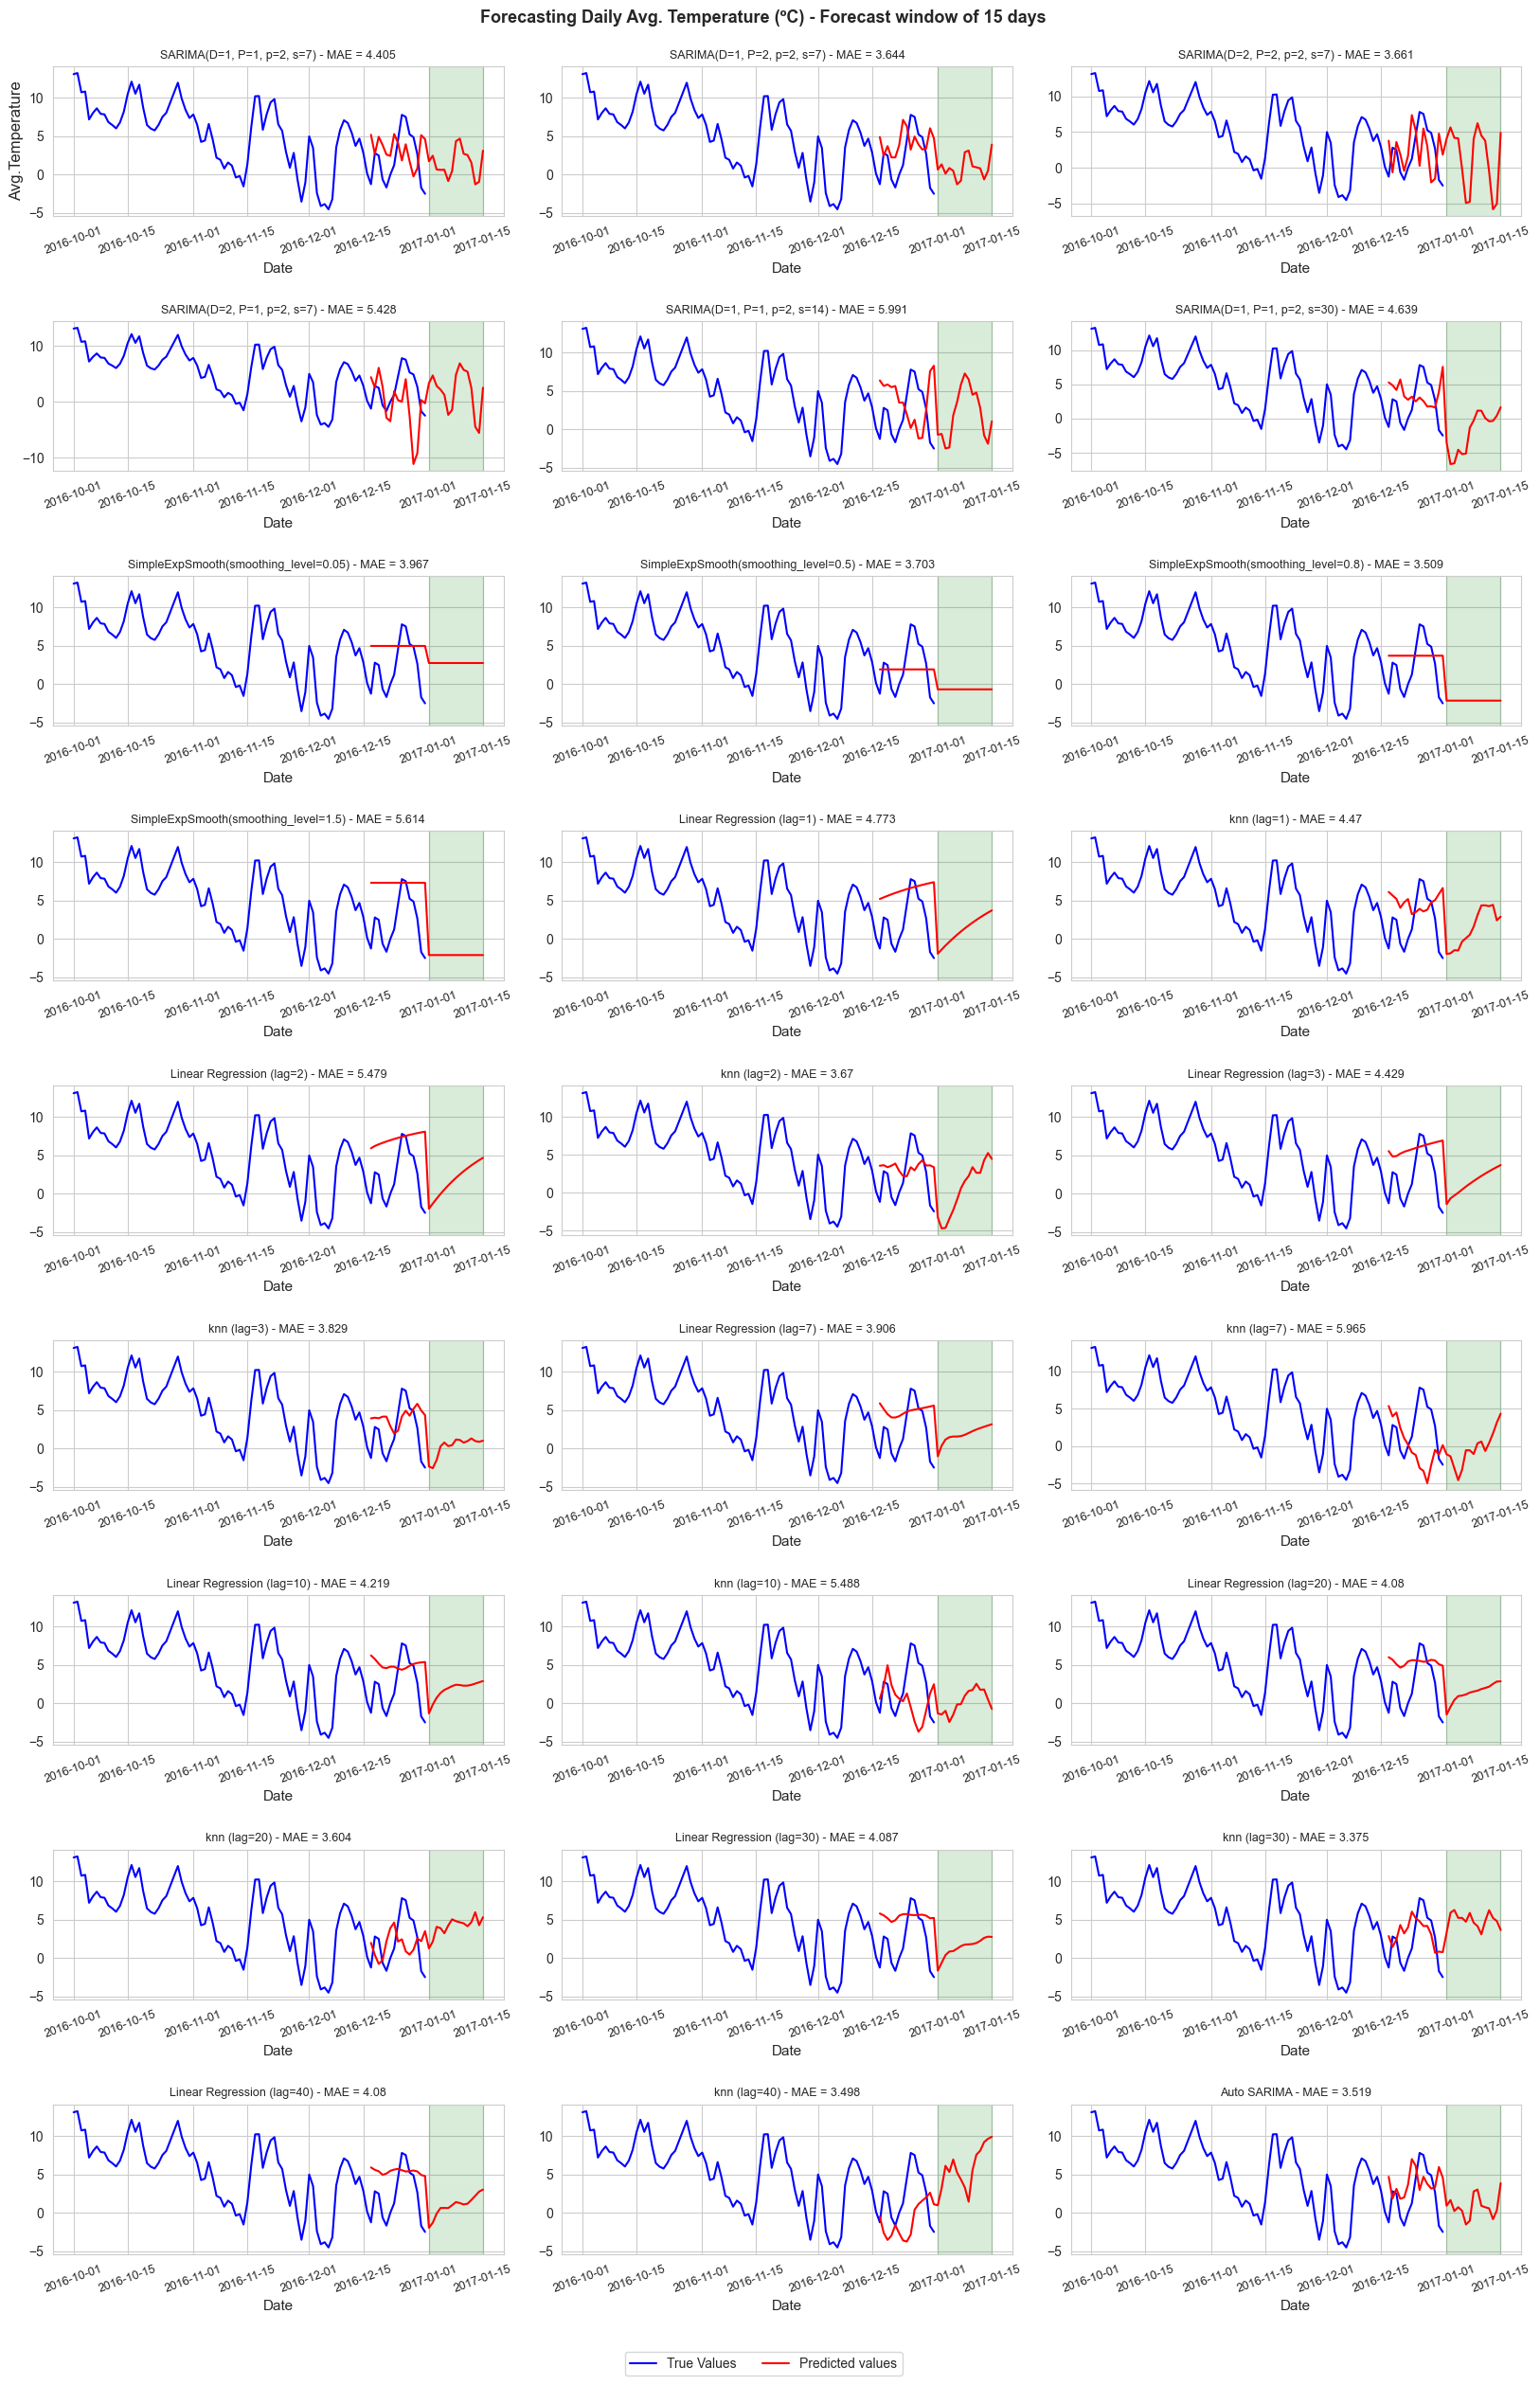

In [50]:
# Plotting test and future forecast

predicted_values = Y_hat
prediction_dates = test_dates + forecasting_dates

predictive_time_series_plot(n_cols=3, figsize=(20,30), 
                            data=df['T'].filter(pl.col('year')==2016, pl.col('month').is_in([10, 11, 12])), 
                            x_name='date', y_name='T', true_color='blue', pred_color='red',
                            predicted_values=predicted_values, prediction_dates=prediction_dates, test_window=test_window, scores=scores, score_name='MAE',
                            title=f"Forecasting Daily Avg. Temperature (ºC) - Forecast window of {forecast_window} days", 
                            title_size=13, title_weight='bold', subtitles_size=9,
                            marker='', markersize=5, ylabel='Avg.Temperature', xlabel='Date',
                            xticks_size=9, hspace=0.7, wspace=0.13, xticks_rotation=20, xlabel_size=11, ylabel_size=11,
                            title_height=0.9, shadow_alpha=0.15, shadow_color='green', legend_size=10, bbox_to_anchor=(0.5,0.065))


In [51]:
''''
# Only plotting future forecast 

predicted_values = Y_future_hat
prediction_dates = forecasting_dates
test_window = None

predictive_time_series_plot(n_cols=3, figsize=(15,15), 
                            data=temp_day_df.filter(pl.col('year')==2016, pl.col('month').is_in([10, 11, 12])), 
                            x_name='date', y_name='T', true_color='blue', pred_color='red',
                            predicted_values=predicted_values, prediction_dates=prediction_dates, test_window=test_window, scores=score, score_name='MAE',
                            title=f"Forecasting Daily Avg.Temperature - Forecast window of {forecast_window} days", 
                            title_size=13, title_weight='bold', subtitles_size=9,
                            marker='', markersize=5, ylabel='Avg.Temperature', xlabel='Date',
                            xticks_size=9, hspace=0.7, wspace=0.13, xticks_rotation=20, xlabel_size=11, ylabel_size=11,
                            title_height=0.93, shadow_alpha=0.15, shadow_color='green', legend_size=10)
'''

'\'\n# Only plotting future forecast \n\npredicted_values = Y_future_hat\nprediction_dates = forecasting_dates\ntest_window = None\n\npredictive_time_series_plot(n_cols=3, figsize=(15,15), \n                            data=temp_day_df.filter(pl.col(\'year\')==2016, pl.col(\'month\').is_in([10, 11, 12])), \n                            x_name=\'date\', y_name=\'T\', true_color=\'blue\', pred_color=\'red\',\n                            predicted_values=predicted_values, prediction_dates=prediction_dates, test_window=test_window, scores=score, score_name=\'MAE\',\n                            title=f"Forecasting Daily Avg.Temperature - Forecast window of {forecast_window} days", \n                            title_size=13, title_weight=\'bold\', subtitles_size=9,\n                            marker=\'\', markersize=5, ylabel=\'Avg.Temperature\', xlabel=\'Date\',\n                            xticks_size=9, hspace=0.7, wspace=0.13, xticks_rotation=20, xlabel_size=11, ylabel_size=11,\n       

In [52]:
'''
# Only plotting test forecast

predicted_values = Y_test_hat
prediction_dates = test_dates 
shadow_alpha = 0

predictive_time_series_plot(n_cols=3, figsize=(15,15), 
                            data=temp_day_df.filter(pl.col('year')==2016, pl.col('month').is_in([10, 11, 12])), 
                            x_name='date', y_name='T', true_color='blue', pred_color='red',
                            predicted_values=predicted_values, prediction_dates=prediction_dates, test_window=test_window, scores=score, score_name='MAE',
                            title=f"Forecasting Daily Avg.Temperature - Forecast window of {forecast_window} days", 
                            title_size=13, title_weight='bold', subtitles_size=9,
                            marker='', markersize=5, ylabel='Avg.Temperature', xlabel='Date',
                            xticks_size=9, hspace=0.7, wspace=0.13, xticks_rotation=20, xlabel_size=11, ylabel_size=11,
                            title_height=0.93, shadow_alpha=shadow_alpha, shadow_color='green', legend_size=10)
'''

'\n# Only plotting test forecast\n\npredicted_values = Y_test_hat\nprediction_dates = test_dates \nshadow_alpha = 0\n\npredictive_time_series_plot(n_cols=3, figsize=(15,15), \n                            data=temp_day_df.filter(pl.col(\'year\')==2016, pl.col(\'month\').is_in([10, 11, 12])), \n                            x_name=\'date\', y_name=\'T\', true_color=\'blue\', pred_color=\'red\',\n                            predicted_values=predicted_values, prediction_dates=prediction_dates, test_window=test_window, scores=score, score_name=\'MAE\',\n                            title=f"Forecasting Daily Avg.Temperature - Forecast window of {forecast_window} days", \n                            title_size=13, title_weight=\'bold\', subtitles_size=9,\n                            marker=\'\', markersize=5, ylabel=\'Avg.Temperature\', xlabel=\'Date\',\n                            xticks_size=9, hspace=0.7, wspace=0.13, xticks_rotation=20, xlabel_size=11, ylabel_size=11,\n                      

##### **Selecting the best model**

Given the previous results, in this section we get the best model, that is, the one with the least inner error.

In [53]:
model_names = list(scores.keys())
inner_scores_values = np.array(list(scores.values()))
best_model_SV = model_names[np.argmin(inner_scores_values)]

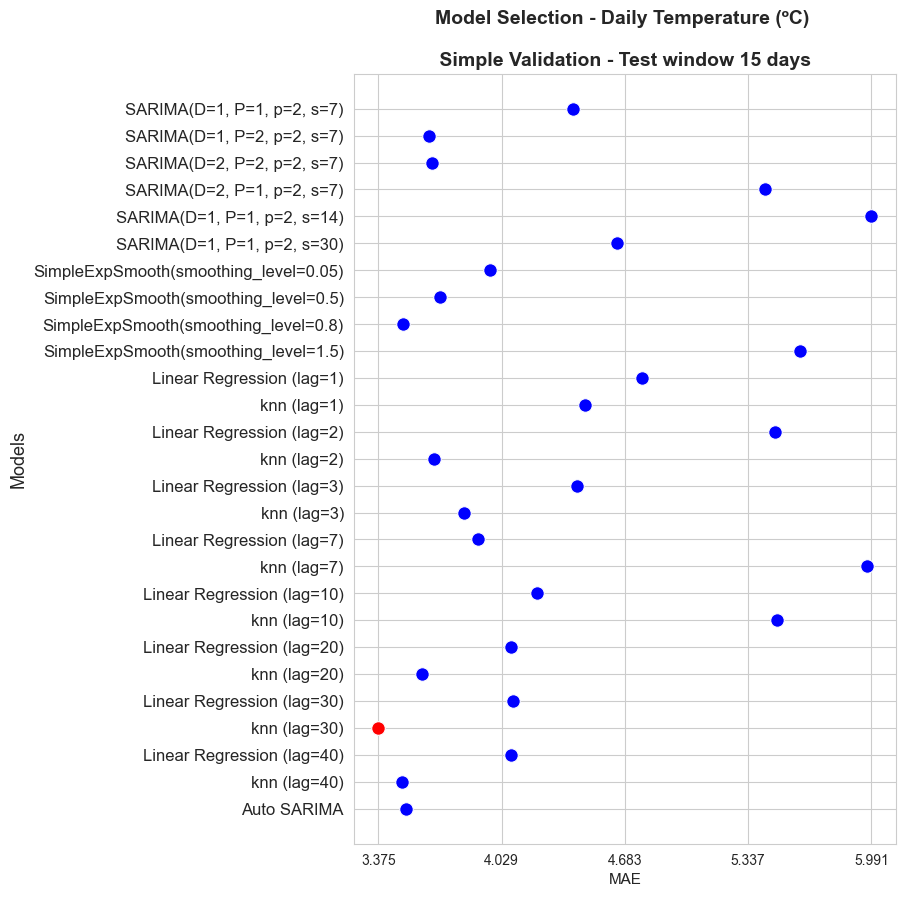

The best model according to simple validation is knn (lag=30)


In [54]:
plt.figure(figsize=(7, 10))
ax = sns.scatterplot(x=inner_scores_values, y=model_names, color='blue', s=95)
ax = sns.scatterplot(x=np.min(inner_scores_values), 
                     y=[best_model_SV], color='red', s=95)
plt.title(f'Model Selection - Daily Temperature (ºC) \n\n Simple Validation - Test window {test_window} days ', size=14, weight='bold')
ax.set_ylabel('Models', size=13)
ax.set_xlabel('MAE', size=11)
min = np.min(inner_scores_values)
max = np.max(inner_scores_values)
plt.xticks(np.round(np.linspace(min,max, 5), 3), fontsize=10)
plt.yticks(fontsize=12)
plt.show()
print('The best model according to simple validation is', best_model_SV)

According to simple validation with a test window fo 15 days, the best model for forecasting the temperature in Jena is the KNN algorithm with 30 lags.

As we can see the lags have a crucial influence in the forecasting results.

#### **Cross Validation**

We perform the same as before but using K-Fold cross validation, with $K=10$.  

This is a much more accurate approach to estimate the (inner) error of a model, and this is specially true in time series where the forecast error could be very dependent on the train-validate   partitions. 
This method makes the estimation less dependent on that, since the model is trained and  evaluated in  different partitions, making the estimation more robust and  precise. 

In [55]:
n_splits = 10
scores = {}
series = 'T'

- Computing inner score by K-Fold CV for `statsmodels` implementation

In [56]:
for name, model in zip(st_models[series].keys(), st_models[series].values()):
    print(name)

    scores[name] = KFold_score_time_series(estimator=model, 
                                          X=X_train_st[series], y=Y_train_st[series], 
                                          n_splits=n_splits, test_window=test_window, 
                                          scoring=mean_absolute_error)                                    

SARIMA(D=1, P=1, p=2, s=7)
Fold's size: 290. Train size: 275. Test size: 15
SARIMA(D=1, P=2, p=2, s=7)
Fold's size: 290. Train size: 275. Test size: 15


SARIMA(D=2, P=2, p=2, s=7)
Fold's size: 290. Train size: 275. Test size: 15
SARIMA(D=2, P=1, p=2, s=7)
Fold's size: 290. Train size: 275. Test size: 15
SARIMA(D=1, P=1, p=2, s=14)
Fold's size: 290. Train size: 275. Test size: 15
SARIMA(D=1, P=1, p=2, s=30)
Fold's size: 290. Train size: 275. Test size: 15
SimpleExpSmooth(smoothing_level=0.05)
Fold's size: 290. Train size: 275. Test size: 15
SimpleExpSmooth(smoothing_level=0.5)
Fold's size: 290. Train size: 275. Test size: 15
SimpleExpSmooth(smoothing_level=0.8)
Fold's size: 290. Train size: 275. Test size: 15
SimpleExpSmooth(smoothing_level=1.5)
Fold's size: 290. Train size: 275. Test size: 15


- Computing inner score by K-Fold CV for `sklearn` implementation

In [57]:
for lag in lags_grid:
    print(lag)

    for name, model in zip(sk_models.keys(), sk_models.values()):
        print(name)

        scores[name + f' (lag={lag})'] = KFold_score_time_series(estimator=model, 
                                            X=X_train_sk[series][lag], y=Y_train_sk[series][lag], 
                                            n_splits=n_splits, test_window=test_window, 
                                            scoring=mean_absolute_error)                                    

1
Linear Regression
Fold's size: 290. Train size: 275. Test size: 15
knn
Fold's size: 290. Train size: 275. Test size: 15
2
Linear Regression
Fold's size: 290. Train size: 275. Test size: 15
knn
Fold's size: 290. Train size: 275. Test size: 15
3
Linear Regression
Fold's size: 290. Train size: 275. Test size: 15
knn
Fold's size: 290. Train size: 275. Test size: 15
7
Linear Regression
Fold's size: 289. Train size: 274. Test size: 15
knn
Fold's size: 289. Train size: 274. Test size: 15
10
Linear Regression
Fold's size: 289. Train size: 274. Test size: 15
knn
Fold's size: 289. Train size: 274. Test size: 15
20
Linear Regression
Fold's size: 288. Train size: 273. Test size: 15
knn
Fold's size: 288. Train size: 273. Test size: 15


30
Linear Regression
Fold's size: 287. Train size: 272. Test size: 15
knn
Fold's size: 287. Train size: 272. Test size: 15
40
Linear Regression
Fold's size: 286. Train size: 271. Test size: 15
knn
Fold's size: 286. Train size: 271. Test size: 15


- Computing inner score by K-Fold CV for `pdmarima` implementation

In [58]:
name = 'Auto SARIMA'

auto_sarima = autoSARIMA(seasonal=True, m=7, d=0, D=1, start_p=0, start_q=0, max_p=3, max_q=3,
                         suppress_warnings=True, stepwise=True, trace=True)

scores[name] = KFold_score_time_series(estimator=auto_sarima, 
                                          X=X_train_st[series], y=Y_train_st[series], 
                                          n_splits=n_splits, test_window=test_window, 
                                          scoring=mean_absolute_error)                                    

Fold's size: 290. Train size: 275. Test size: 15
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=1482.445, Time=0.16 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=1525.761, Time=0.01 sec


 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=1294.899, Time=0.14 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=1305.493, Time=0.14 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=1527.658, Time=0.00 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=1339.845, Time=0.02 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=1273.720, Time=0.29 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=1235.321, Time=0.62 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=1234.282, Time=0.25 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=1233.493, Time=0.16 sec
 ARIMA(1,0,0)(0,1,2)[7] intercept   : AIC=1234.110, Time=0.27 sec
 ARIMA(1,0,0)(1,1,2)[7] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=1481.386, Time=0.08 sec
 ARIMA(2,0,0)(0,1,1)[7] intercept   : AIC=1232.437, Time=0.22 sec
 ARIMA(2,0,0)(0,1,0)[7] intercept   : AIC=1327.651, Time=0.05 sec
 ARIMA(2,0,0)(1,1,1)[7] intercept   : AIC=1232.780, Time=0.32 sec
 ARIMA(2,0,0)(0,1,2)[7] intercept   : AIC=1232.608, Time=0.39 sec
 ARIMA(2,0,0)(1

##### **Selecting the best model**

Given the previous results, in this section we get the best model, that is, the one with the least inner error.

In [59]:
model_names = np.array(list(scores.keys()))
inner_scores_values = np.array(list(scores.values()))
best_model_CV = model_names[np.argmin(inner_scores_values)]

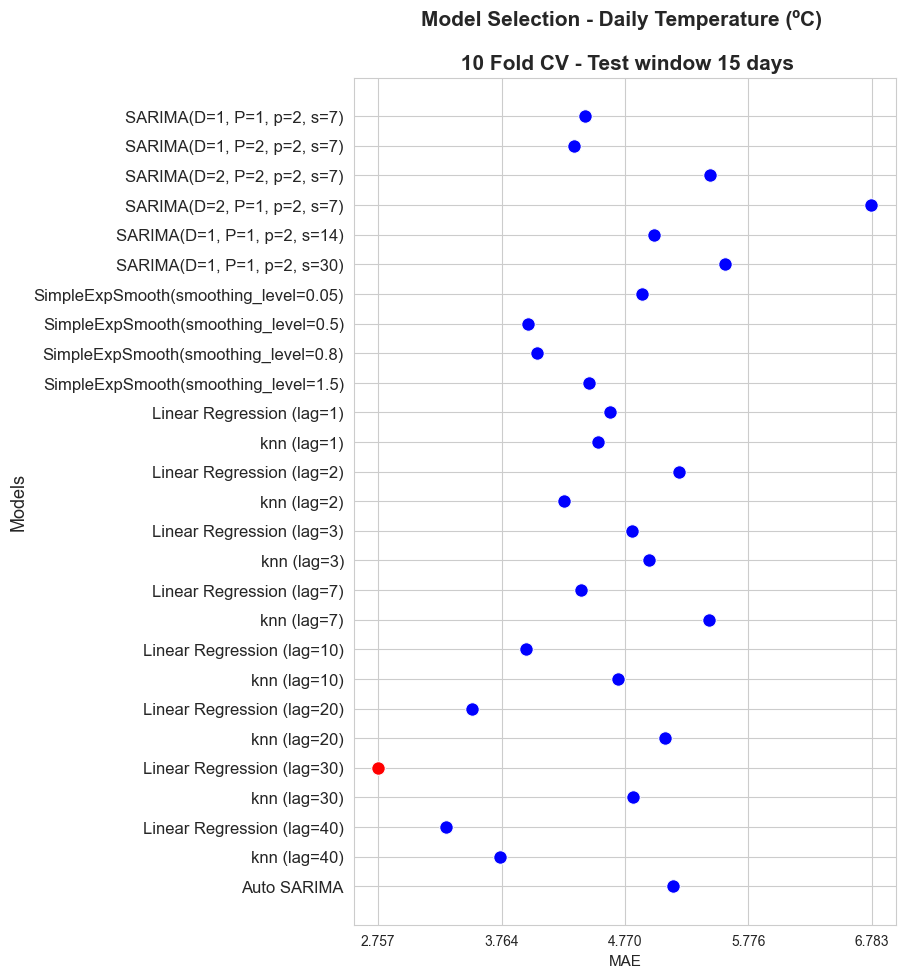

The best model according to cross validation is Linear Regression (lag=30)


In [60]:
plt.figure(figsize=(7, 11))
ax = sns.scatterplot(x=inner_scores_values, y=model_names, color='blue', s=95)
ax = sns.scatterplot(x=np.min(inner_scores_values), 
                     y=[best_model_CV], color='red', s=95)
plt.title(f'Model Selection - Daily Temperature (ºC) \n\n {n_splits} Fold CV - Test window {test_window} days', size=15, weight='bold')
ax.set_ylabel('Models', size=13)
ax.set_xlabel('MAE', size=11)
min = np.min(inner_scores_values)
max = np.max(inner_scores_values)
plt.xticks(np.round(np.linspace(min,max, 5), 3), fontsize=10)
plt.yticks(fontsize=12)
plt.show()
print('The best model according to cross validation is', best_model_CV)

According to cross validation with a test window fo 15 days, the best model for forecasting the temperature in Jena is the Linear Regression  algorithm with 30 lags.

We can see again that the lags have a crucial influence in the forecasting results.

##### **Predictive visualization**

In this section we are going to plot the K-Fold cross validation process applied above for some of the models, just for getting more insight of how it works, and how dependent are the forecast on the train-validate partitions (namely, on the folds).

- $\text{SARIMA}(p=1, d=0, q=0)\times(P=1, D=1, Q=0)_{s=7}$

Fold's size: 290. Train size: 275. Test size: 15


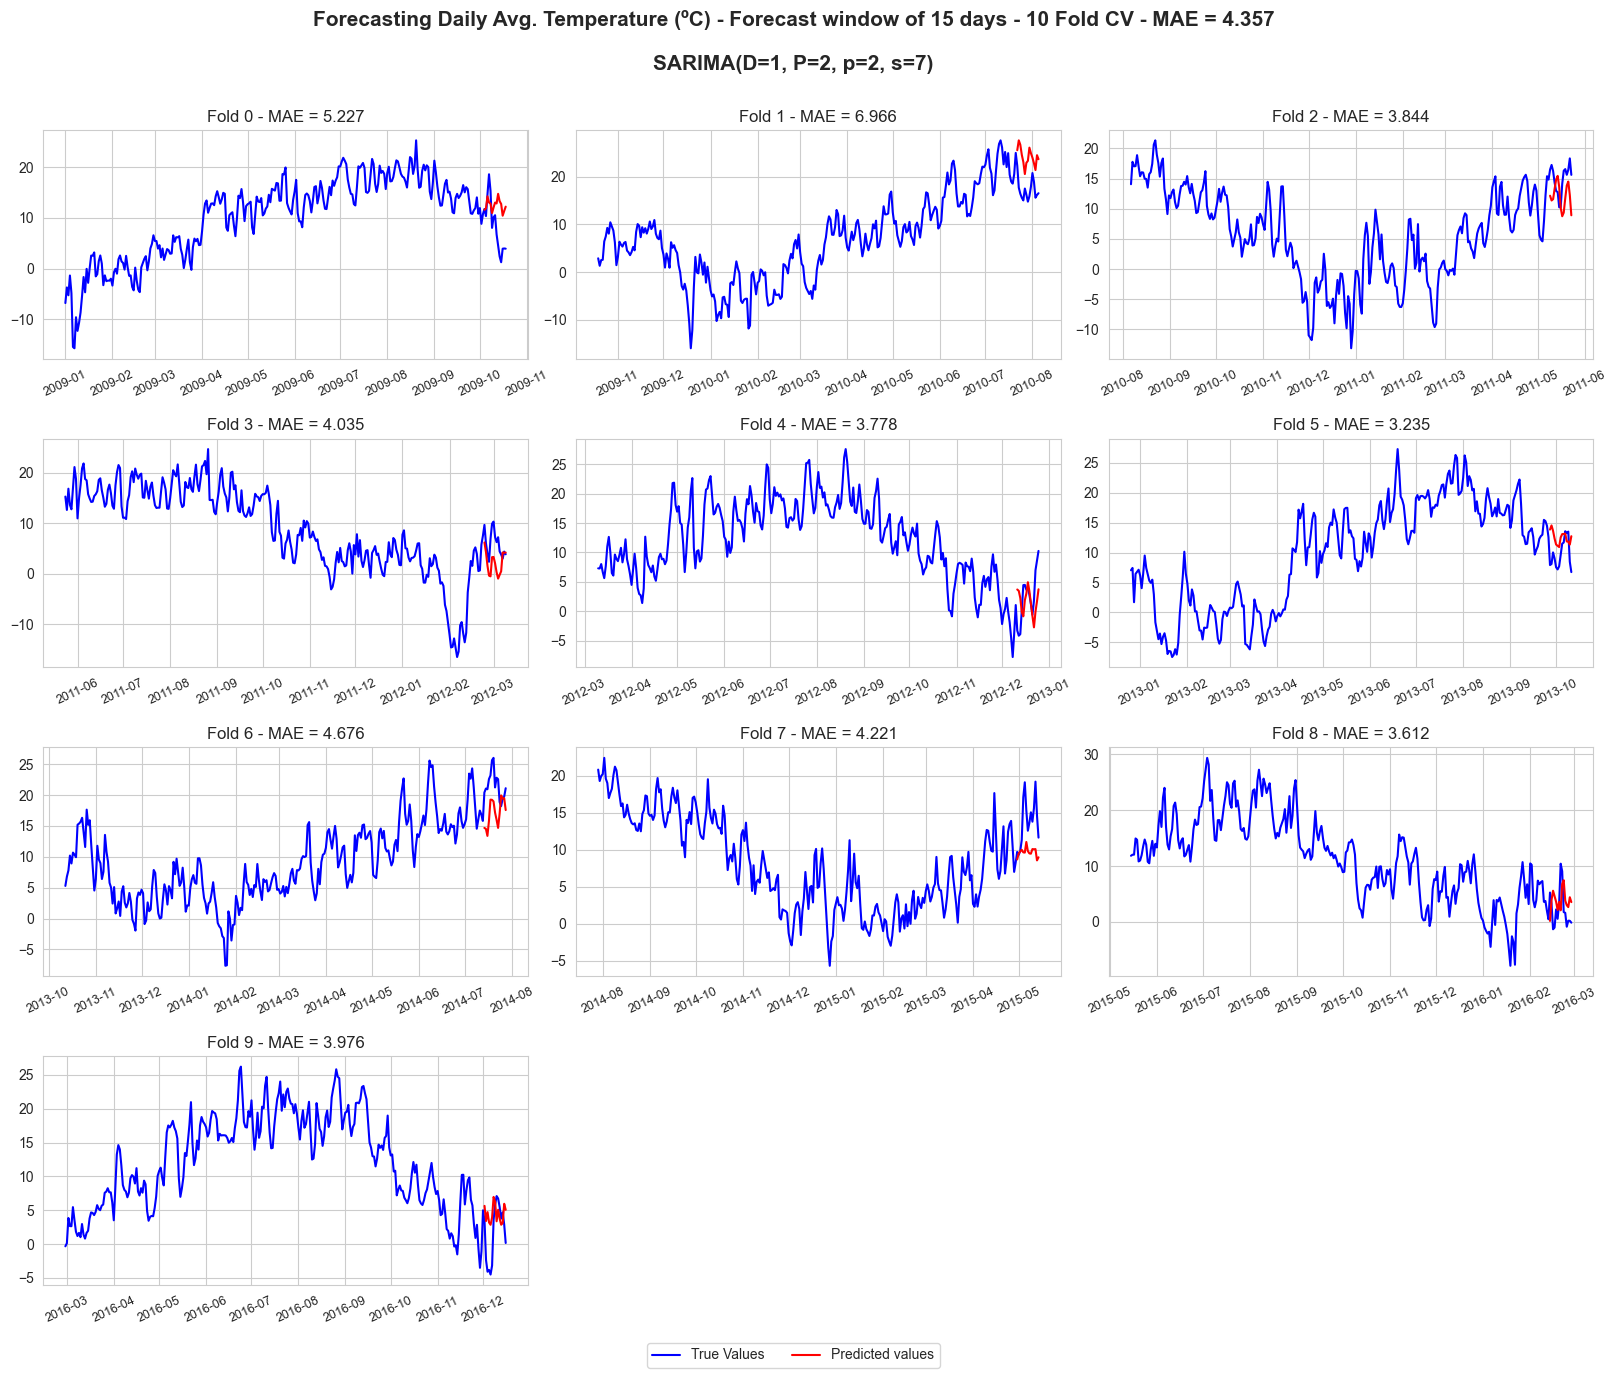

In [61]:
estimator = sarima[series][2]
model_name = str(sarima[series][2])

KFold_time_series_plot(n_cols=3, figsize=(20,15), estimator=estimator, 
                       X=X_train_st[series], y=Y_train_st[series], n_splits=n_splits, test_window=test_window, score=mean_absolute_error, dates=dates,
                       true_color='blue', pred_color='red', marker='', markersize=4,
                       title=f"Forecasting Daily Avg. Temperature (ºC) - Forecast window of {forecast_window} days - {n_splits} Fold CV - MAE = {np.round(scores[model_name],3)}\n\n{model_name}",
                       hspace=0.35, wspace=0.1, subtitles_size=12, title_size=15, xticks_rotation=25, 
                       bbox_to_anchor=(0.5,0.05))

- Linear regression with 30 lags

Fold's size: 287. Train size: 272. Test size: 15


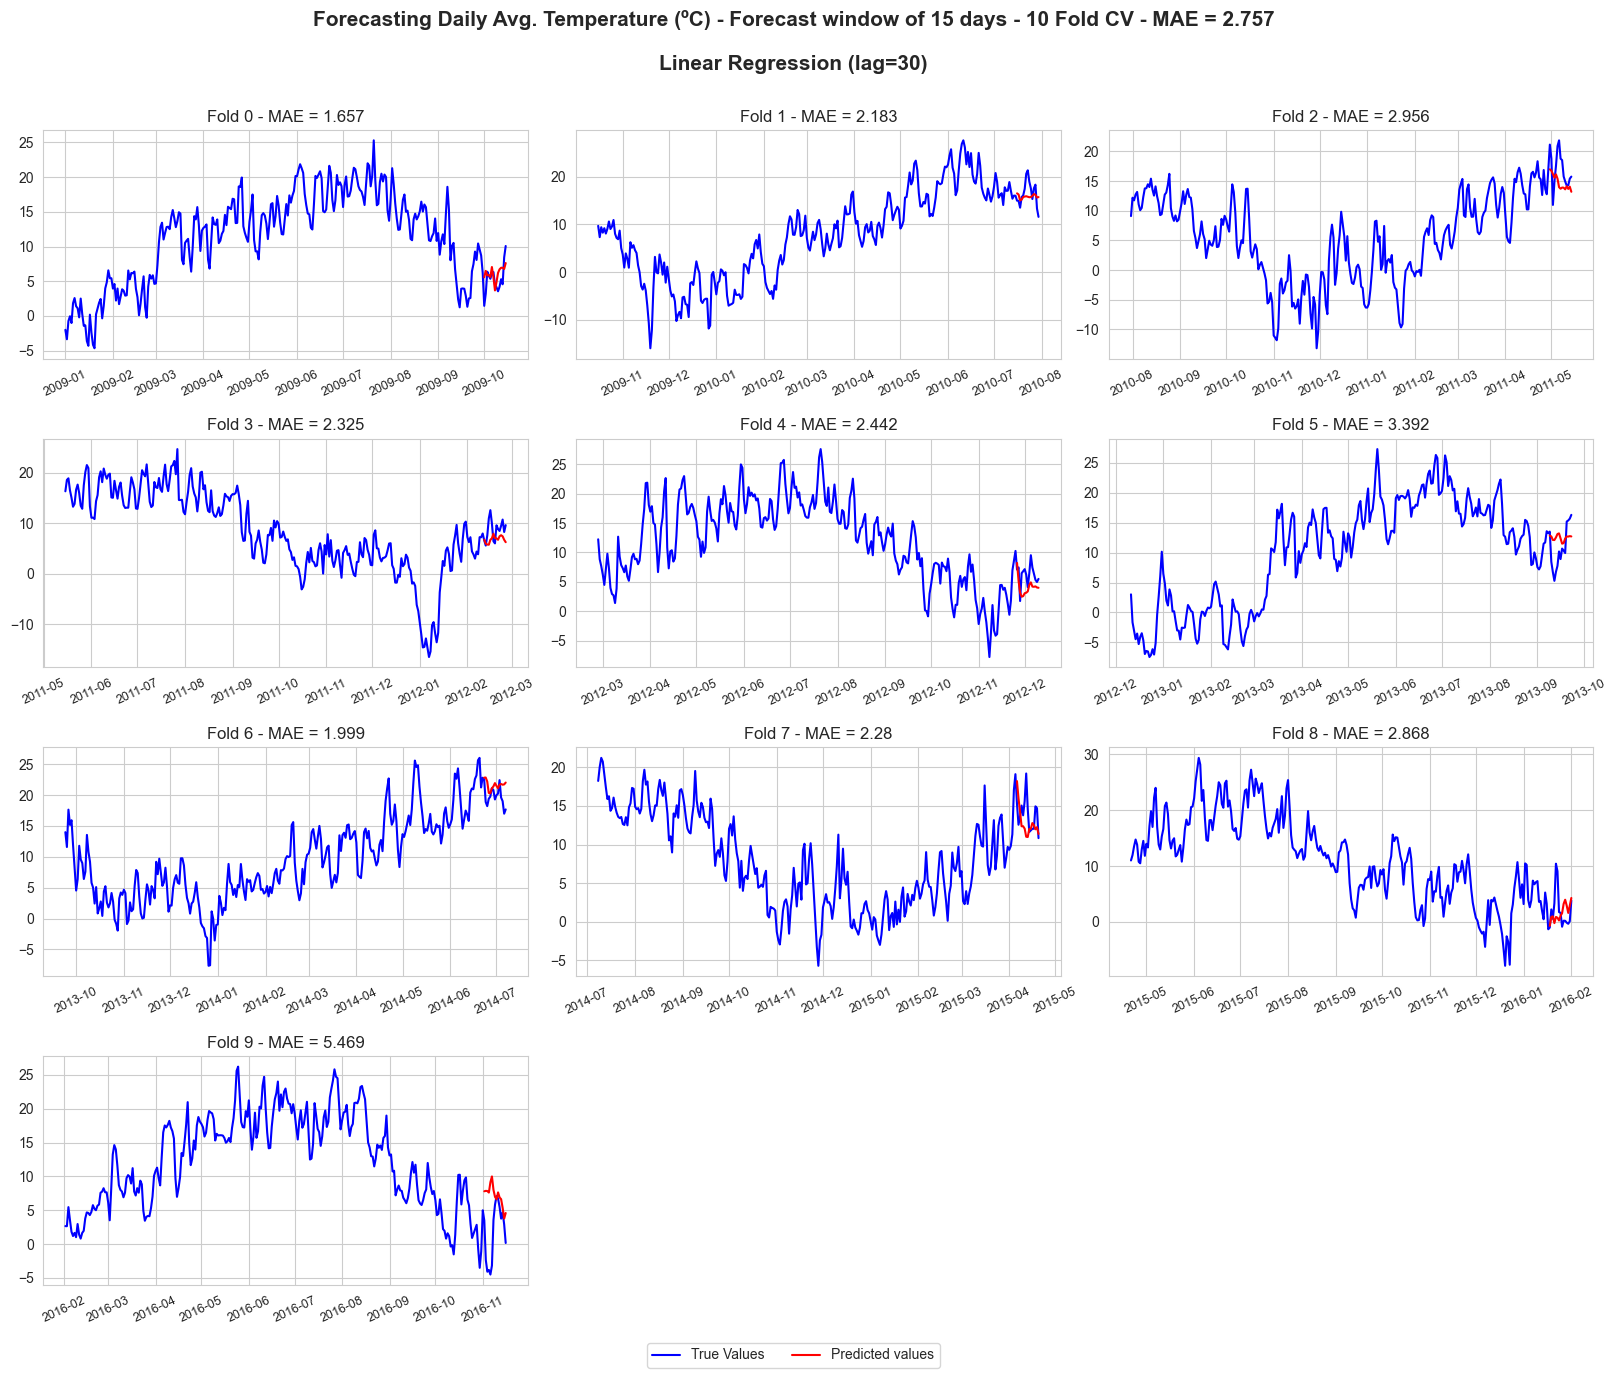

In [62]:
estimator = linear_regression
lag = 30
model_name = f'Linear Regression (lag={lag})'

KFold_time_series_plot(n_cols=3, figsize=(20,15), estimator=estimator,  score=mean_absolute_error,
                       X=X_train_sk[series][lag], y=Y_train_sk[series][lag], n_splits=n_splits, test_window=test_window, dates=dates,
                       true_color='blue', pred_color='red', marker='', markersize=4,
                       title=f"Forecasting Daily Avg. Temperature (ºC) - Forecast window of {forecast_window} days - {n_splits} Fold CV - MAE = {np.round(scores[model_name],3)}\n\n{model_name}",
                       hspace=0.35, wspace=0.1, subtitles_size=12, title_size=15, xticks_rotation=25, 
                       bbox_to_anchor=(0.5,0.05))

##### **Estimation of future performance**

We estimate the future performance of the best model according to KFold Cross Validation. 

This estimates the performance that the best model will have in forecasting the future, but has to be taken carefully since is very dependent on the slot of testing data used, specially in time series. 

So the future performance of a model could be very good for some kinds of test date but much worse for other. 

For example, if the testing set contains a shock the performance of the model will probably be worse than it was in the validation part, that is, the estimation of future performance will be worse than the cross validation error, just because we are forecasting a really unpredictable  period (a shock).

In [63]:
best_model_CV

'Linear Regression (lag=30)'

In [64]:
lag = 30
linear_regression.fit(X=X_train_sk[series][lag], y=Y_train_sk[series][lag])
Y_test_hat = linear_regression.forecast(window=test_window)
estimation_future_performance = mean_absolute_error(y_pred=Y_test_hat, y_true=Y_test_sk[series][lag])
estimation_future_performance

3.0046182746521652

Now we are going to repeat the previous steps (the ones associated to the cross validation part) for the remaining  two series, humidity and wind speed.

### **Humidity (`rh`)**

#### **Cross Validation**

In [65]:
n_splits = 10
scores = {}
series = 'rh'

- Computing inner score by K-Fold CV for `statsmodels` implementation

In [66]:
for name, model in zip(st_models[series].keys(), st_models[series].values()):
    print(name)

    scores[name] = KFold_score_time_series(estimator=model, 
                                          X=X_train_st[series], y=Y_train_st[series], 
                                          n_splits=n_splits, test_window=test_window, 
                                          scoring=mean_absolute_error)                                    

SARIMA(D=1, P=1, p=1, s=7)
Fold's size: 290. Train size: 275. Test size: 15
SARIMA(D=1, P=1, p=2, s=7)
Fold's size: 290. Train size: 275. Test size: 15


SARIMA(D=1, P=2, p=1, s=7)
Fold's size: 290. Train size: 275. Test size: 15
SARIMA(D=2, P=2, p=1, s=7)
Fold's size: 290. Train size: 275. Test size: 15
SARIMA(D=1, P=2, p=2, s=7)
Fold's size: 290. Train size: 275. Test size: 15
SARIMA(D=2, P=2, p=2, s=7)
Fold's size: 290. Train size: 275. Test size: 15
SARIMA(D=1, P=1, p=1, s=14)
Fold's size: 290. Train size: 275. Test size: 15
SARIMA(D=1, P=1, p=2, s=14)
Fold's size: 290. Train size: 275. Test size: 15
SimpleExpSmooth(smoothing_level=0.05)
Fold's size: 290. Train size: 275. Test size: 15
SimpleExpSmooth(smoothing_level=0.5)
Fold's size: 290. Train size: 275. Test size: 15
SimpleExpSmooth(smoothing_level=0.8)
Fold's size: 290. Train size: 275. Test size: 15
SimpleExpSmooth(smoothing_level=1.5)
Fold's size: 290. Train size: 275. Test size: 15


- Computing inner score by K-Fold CV for `sklearn` implementation

In [67]:
for lag in lags_grid:
    print(lag)

    for name, model in zip(sk_models.keys(), sk_models.values()):
        print(name)

        scores[name + f' (lag={lag})'] = KFold_score_time_series(estimator=model, 
                                            X=X_train_sk[series][lag], y=Y_train_sk[series][lag], 
                                            n_splits=n_splits, test_window=test_window, 
                                            scoring=mean_absolute_error)                                    

1
Linear Regression
Fold's size: 290. Train size: 275. Test size: 15
knn
Fold's size: 290. Train size: 275. Test size: 15
2
Linear Regression
Fold's size: 290. Train size: 275. Test size: 15
knn
Fold's size: 290. Train size: 275. Test size: 15
3
Linear Regression
Fold's size: 290. Train size: 275. Test size: 15
knn
Fold's size: 290. Train size: 275. Test size: 15
7
Linear Regression
Fold's size: 289. Train size: 274. Test size: 15
knn
Fold's size: 289. Train size: 274. Test size: 15
10
Linear Regression
Fold's size: 289. Train size: 274. Test size: 15
knn
Fold's size: 289. Train size: 274. Test size: 15
20
Linear Regression
Fold's size: 288. Train size: 273. Test size: 15
knn
Fold's size: 288. Train size: 273. Test size: 15


30
Linear Regression
Fold's size: 287. Train size: 272. Test size: 15
knn
Fold's size: 287. Train size: 272. Test size: 15
40
Linear Regression
Fold's size: 286. Train size: 271. Test size: 15
knn
Fold's size: 286. Train size: 271. Test size: 15


- Computing inner score by K-Fold CV for `pdmarima` implementation

In [68]:
name = 'Auto SARIMA'

auto_sarima = autoSARIMA(seasonal=True, m=7, d=0, D=1, start_p=0, start_q=0, max_p=3, max_q=3,
                         suppress_warnings=True, stepwise=True, trace=True)

scores[name] = KFold_score_time_series(estimator=auto_sarima, 
                                          X=X_train_st[series], y=Y_train_st[series], 
                                          n_splits=n_splits, test_window=test_window, 
                                          scoring=mean_absolute_error)                                    

Fold's size: 290. Train size: 275. Test size: 15
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=2119.118, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=1998.953, Time=0.16 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=2117.162, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=2054.646, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=1972.934, Time=0.34 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=2045.514, Time=0.51 sec
 ARIMA(2,0,0)(2,1,0)[7] intercept   : AIC=1953.354, Time=0.39 sec
 ARIMA(2,0,0)(1,1,0)[7] intercept   : AIC=1972.645, Time=0.17 sec
 ARIMA(2,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(2,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(3,0,0)(

##### **Selecting the best model**

Given the previous results, in this section we get the best model, that is, the one with the least inner error.

In [69]:
model_names = np.array(list(scores.keys()))
inner_scores_values = np.array(list(scores.values()))
best_model_CV = model_names[np.argmin(inner_scores_values)]

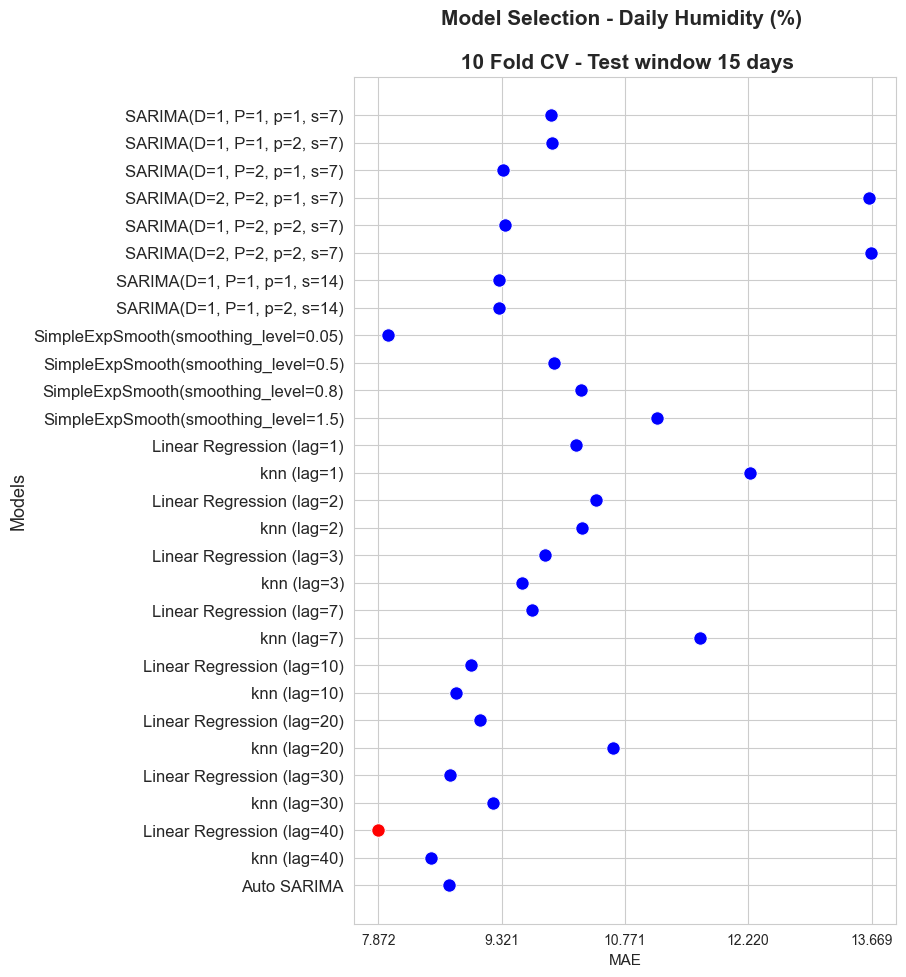

The best model according to cross validation is Linear Regression (lag=40)


In [70]:
plt.figure(figsize=(7, 11))
ax = sns.scatterplot(x=inner_scores_values, y=model_names, color='blue', s=95)
ax = sns.scatterplot(x=np.min(inner_scores_values), 
                     y=[best_model_CV], color='red', s=95)
plt.title(f'Model Selection - Daily Humidity (%) \n\n {n_splits} Fold CV - Test window {test_window} days', size=15, weight='bold')
ax.set_ylabel('Models', size=13)
ax.set_xlabel('MAE', size=11)
min = np.min(inner_scores_values)
max = np.max(inner_scores_values)
plt.xticks(np.round(np.linspace(min,max, 5), 3), fontsize=10)
plt.yticks(fontsize=12)
plt.show()
print('The best model according to cross validation is', best_model_CV)

According to cross validation with a test window fo 15 days, the best model for forecasting the humidity in Jena is the Linear Regression  algorithm with 40 lags.

We can see again that the lags have a crucial influence in the forecasting results.

##### **Predictive visualization**

In this section we are going to plot the K-Fold cross validation process applied above for some of the models, just for getting more insight of how it works, and how dependent are the forecast on the train-validate partitions (namely, on the folds).

- SARIMA $(p=1, d=0, q=0)\times(P=1, D=1, Q=0)_{s=7}$

Fold's size: 290. Train size: 275. Test size: 15


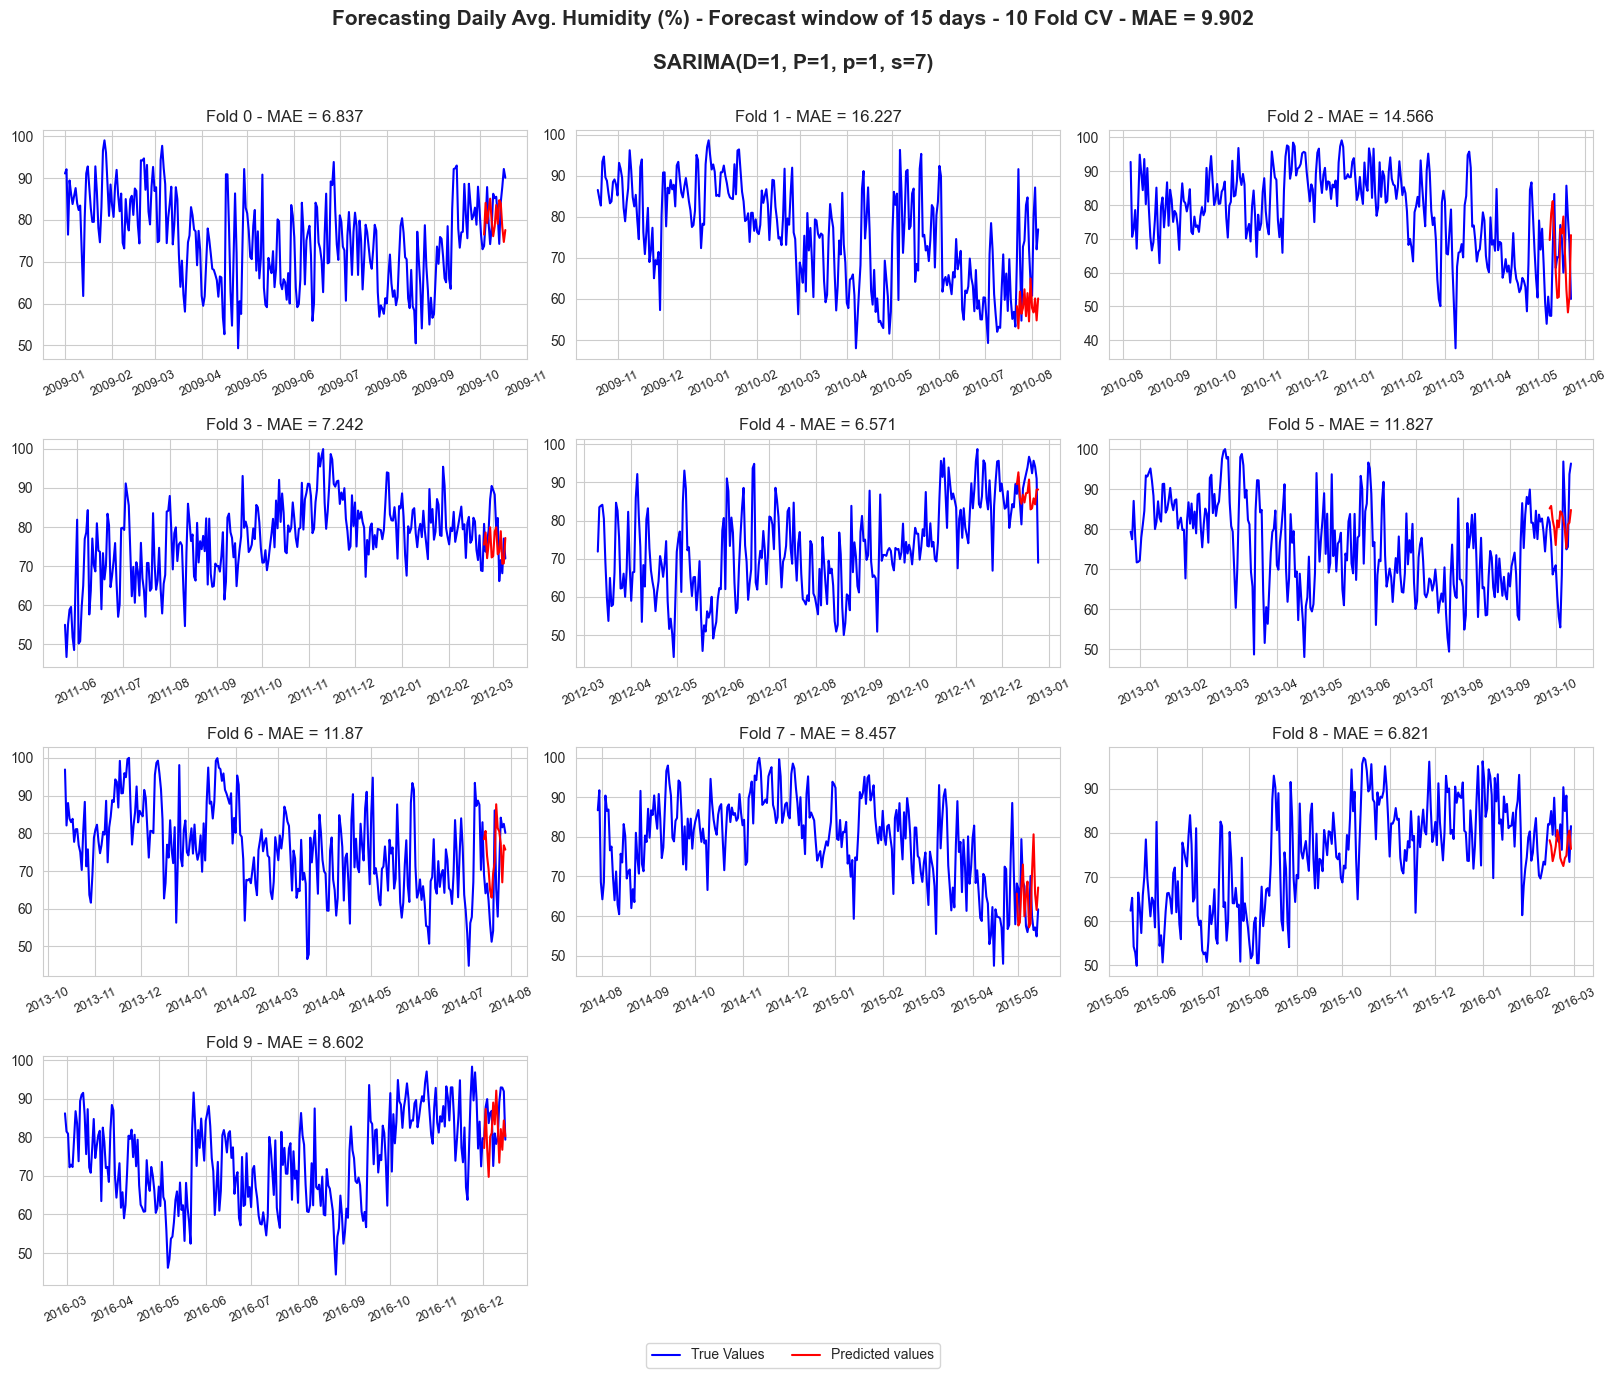

In [71]:
estimator = sarima[series][1]
model_name = str(sarima[series][1])

KFold_time_series_plot(n_cols=3, figsize=(20,15), estimator=estimator, 
                       X=X_train_st[series], y=Y_train_st[series], n_splits=n_splits, test_window=test_window, score=mean_absolute_error, dates=dates,
                       true_color='blue', pred_color='red', marker='', markersize=4,
                       title=f"Forecasting Daily Avg. Humidity (%) - Forecast window of {forecast_window} days - {n_splits} Fold CV - MAE = {np.round(scores[model_name],3)}\n\n{model_name}",
                       hspace=0.35, wspace=0.1, subtitles_size=12, title_size=15, xticks_rotation=25, 
                       bbox_to_anchor=(0.5,0.05))

- Linear regression with 40 lags

Fold's size: 286. Train size: 271. Test size: 15


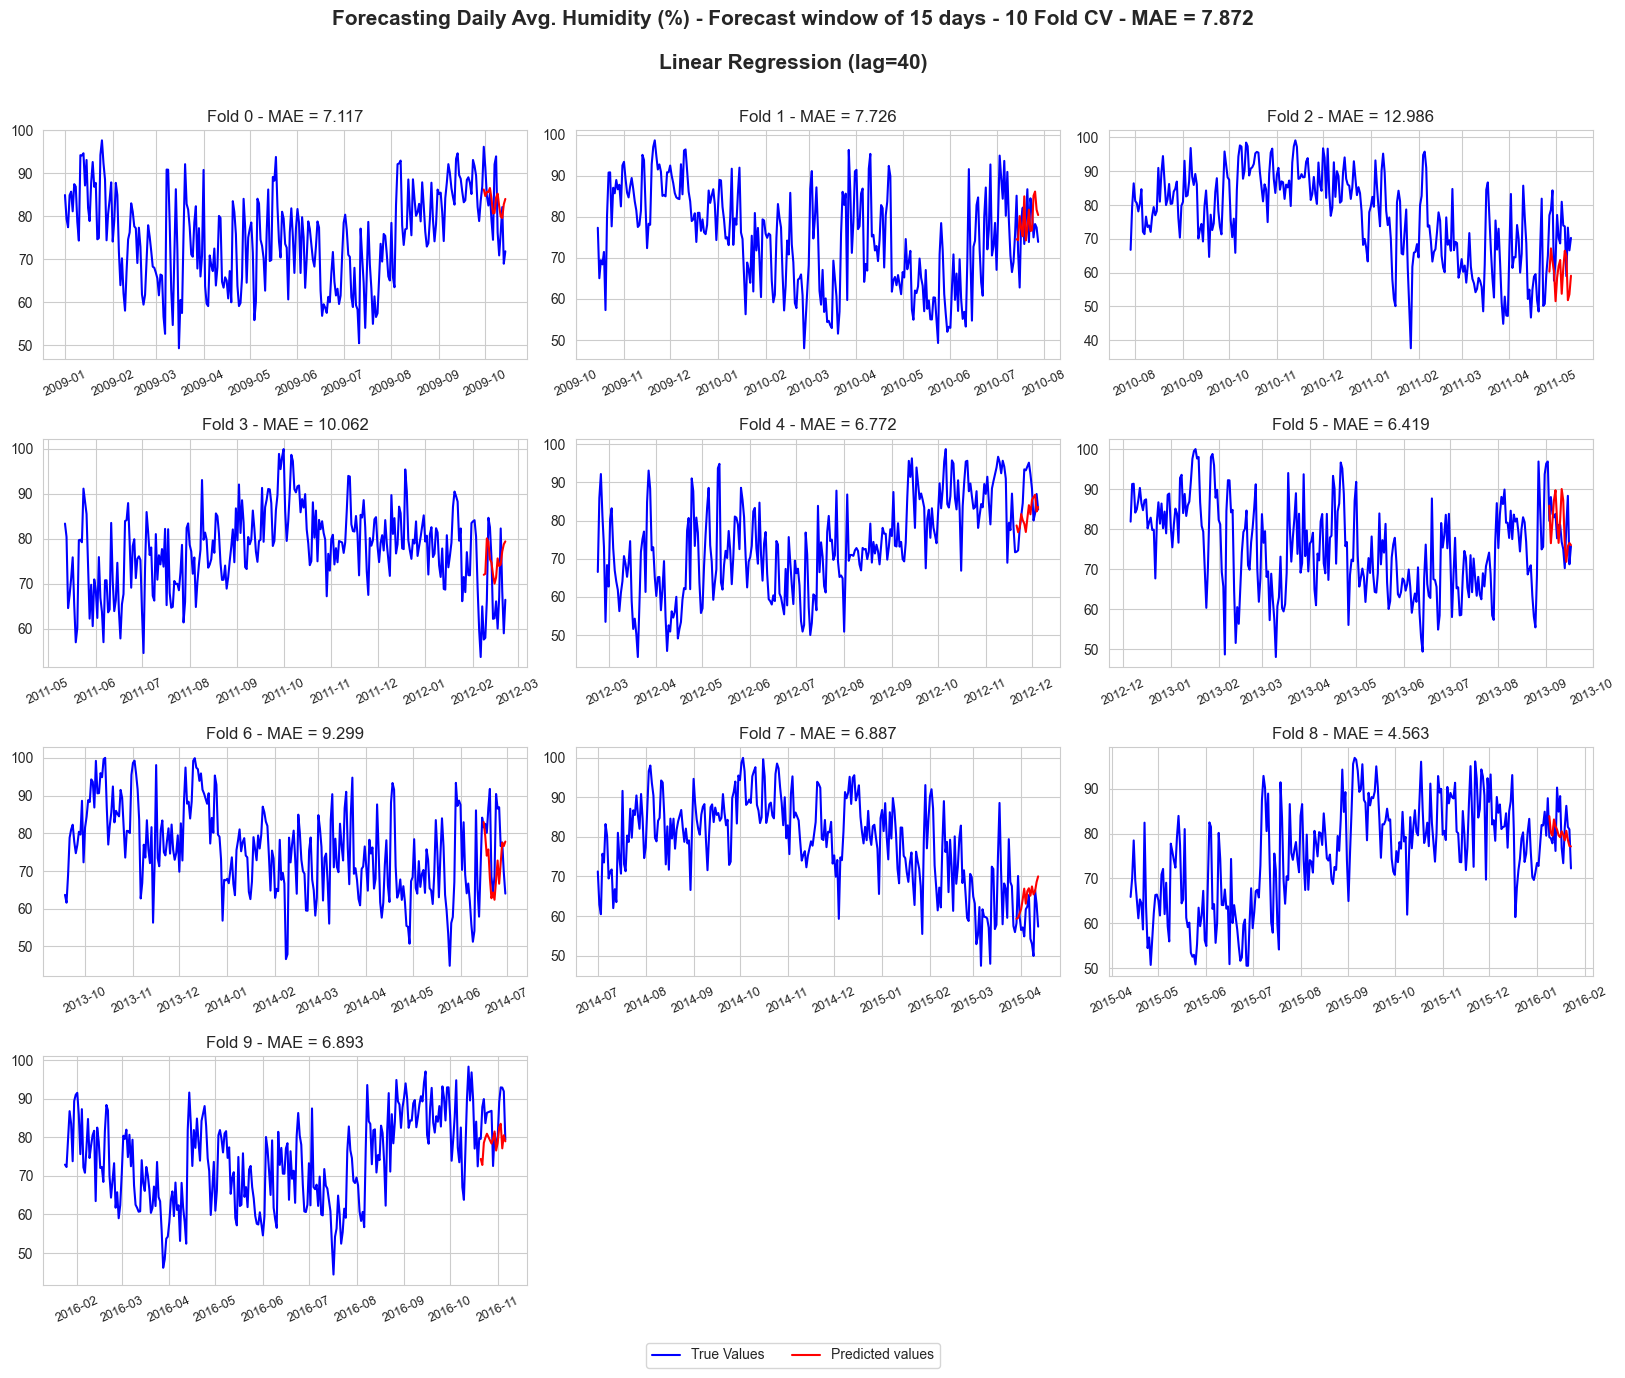

In [72]:
estimator = linear_regression
lag = 40
model_name = f'Linear Regression (lag={lag})'

KFold_time_series_plot(n_cols=3, figsize=(20,15), estimator=estimator,  score=mean_absolute_error,
                       X=X_train_sk[series][lag], y=Y_train_sk[series][lag], n_splits=n_splits, test_window=test_window, dates=dates,
                       true_color='blue', pred_color='red', marker='', markersize=4,
                       title=f"Forecasting Daily Avg. Humidity (%) - Forecast window of {forecast_window} days - {n_splits} Fold CV - MAE = {np.round(scores[model_name],3)}\n\n{model_name}",
                       hspace=0.35, wspace=0.1, subtitles_size=12, title_size=15, xticks_rotation=25, 
                       bbox_to_anchor=(0.5,0.05))

##### **Estimation of future performance**

We estimate the future performance of the best model according to KFold Cross Validation.

In [73]:
best_model_CV

'Linear Regression (lag=40)'

In [74]:
lag = 40
linear_regression.fit(X=X_train_sk[series][lag], y=Y_train_sk[series][lag])
Y_test_hat = linear_regression.forecast(window=test_window)
estimation_future_performance = mean_absolute_error(y_pred=Y_test_hat, y_true=Y_test_sk[series][lag])
estimation_future_performance

6.438584620069256

### **Wind Speed (`wv`)**

#### **Cross Validation**

In [75]:
n_splits = 10
scores = {}
series = 'wv'

- Computing inner score by K-Fold CV for `statsmodels` implementation

In [76]:
for name, model in zip(st_models[series].keys(), st_models[series].values()):
    print(name)

    scores[name] = KFold_score_time_series(estimator=model, 
                                          X=X_train_st[series], y=Y_train_st[series], 
                                          n_splits=n_splits, test_window=test_window, 
                                          scoring=mean_absolute_error)                                    

SARIMA(p=1)
Fold's size: 290. Train size: 275. Test size: 15
SARIMA(p=2)
Fold's size: 290. Train size: 275. Test size: 15
SARIMA(p=1, q=1)
Fold's size: 290. Train size: 275. Test size: 15
SARIMA(p=1, q=2)
Fold's size: 290. Train size: 275. Test size: 15


SARIMA(p=2, q=1)
Fold's size: 290. Train size: 275. Test size: 15
SARIMA(p=2, q=2)
Fold's size: 290. Train size: 275. Test size: 15
SimpleExpSmooth(smoothing_level=0.05)
Fold's size: 290. Train size: 275. Test size: 15
SimpleExpSmooth(smoothing_level=0.5)
Fold's size: 290. Train size: 275. Test size: 15
SimpleExpSmooth(smoothing_level=0.8)
Fold's size: 290. Train size: 275. Test size: 15
SimpleExpSmooth(smoothing_level=1.5)
Fold's size: 290. Train size: 275. Test size: 15


- Computing inner score by K-Fold CV for `sklearn` implementation

In [77]:
for lag in lags_grid:
    print(lag)

    for name, model in zip(sk_models.keys(), sk_models.values()):
        print(name)

        scores[name + f' (lag={lag})'] = KFold_score_time_series(estimator=model, 
                                            X=X_train_sk[series][lag], y=Y_train_sk[series][lag], 
                                            n_splits=n_splits, test_window=test_window, 
                                            scoring=mean_absolute_error)                                    

1
Linear Regression
Fold's size: 290. Train size: 275. Test size: 15
knn
Fold's size: 290. Train size: 275. Test size: 15
2
Linear Regression
Fold's size: 290. Train size: 275. Test size: 15
knn
Fold's size: 290. Train size: 275. Test size: 15
3
Linear Regression
Fold's size: 290. Train size: 275. Test size: 15
knn
Fold's size: 290. Train size: 275. Test size: 15
7
Linear Regression
Fold's size: 289. Train size: 274. Test size: 15
knn
Fold's size: 289. Train size: 274. Test size: 15
10
Linear Regression
Fold's size: 289. Train size: 274. Test size: 15
knn
Fold's size: 289. Train size: 274. Test size: 15
20
Linear Regression
Fold's size: 288. Train size: 273. Test size: 15


knn
Fold's size: 288. Train size: 273. Test size: 15
30
Linear Regression
Fold's size: 287. Train size: 272. Test size: 15
knn
Fold's size: 287. Train size: 272. Test size: 15
40
Linear Regression
Fold's size: 286. Train size: 271. Test size: 15
knn
Fold's size: 286. Train size: 271. Test size: 15


- Computing inner score by K-Fold CV for `pdmarima` implementation

In [78]:
name = 'Auto SARIMA'

auto_sarima = autoSARIMA(seasonal=True, m=7, d=0, D=1, start_p=0, start_q=0, max_p=3, max_q=3,
                         suppress_warnings=True, stepwise=True, trace=True)

scores[name] = KFold_score_time_series(estimator=auto_sarima, 
                                          X=X_train_st[series], y=Y_train_st[series], 
                                          n_splits=n_splits, test_window=test_window, 
                                          scoring=mean_absolute_error)                                    

Fold's size: 290. Train size: 275. Test size: 15
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=815.877, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=697.372, Time=0.13 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=813.894, Time=0.00 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=763.906, Time=0.02 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=678.813, Time=0.31 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=726.068, Time=0.28 sec
 ARIMA(2,0,0)(2,1,0)[7] intercept   : AIC=676.668, Time=0.29 sec
 ARIMA(2,0,0)(1,1,0)[7] intercept   : AIC=693.946, Time=0.15 sec
 ARIMA(2,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(2,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(3,0,0)(2,1,0)[7

##### **Selecting the best model**

Given the previous results, in this section we get the best model, that is, the one with the least inner error.

In [79]:
model_names = np.array(list(scores.keys()))
inner_scores_values = np.array(list(scores.values()))
best_model_CV = model_names[np.argmin(inner_scores_values)]

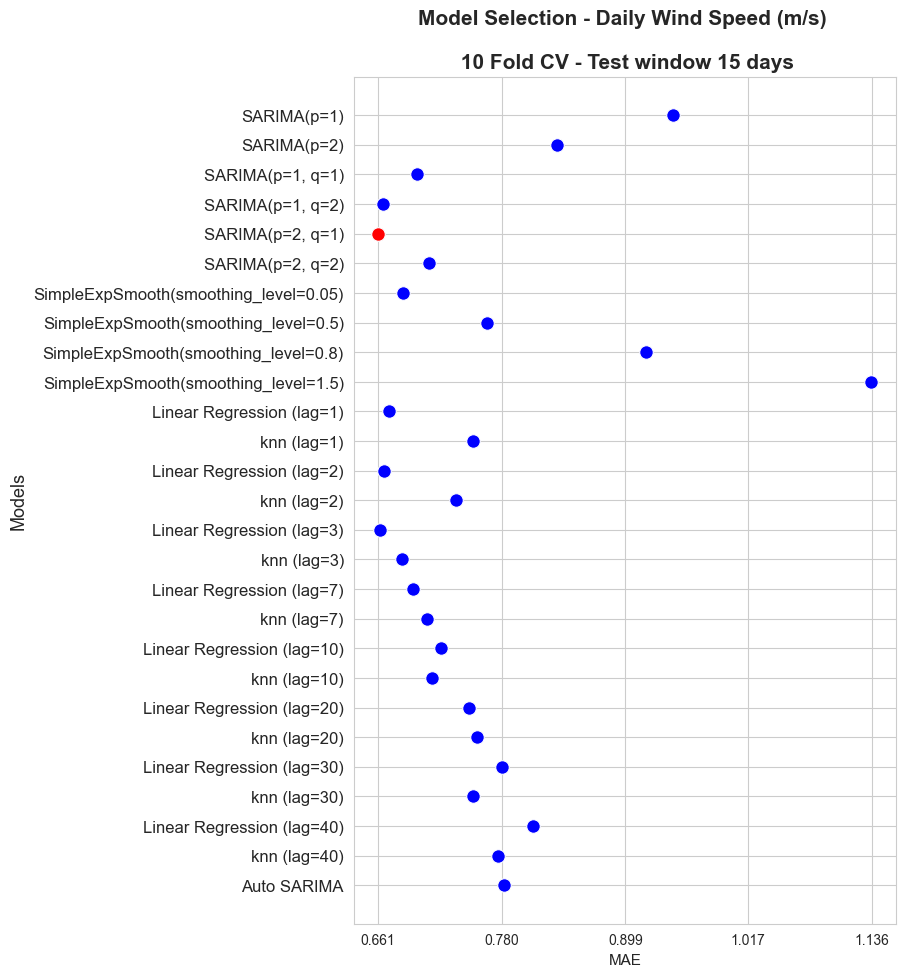

The best model according to cross validation is SARIMA(p=2, q=1)


In [80]:
plt.figure(figsize=(7, 11))
ax = sns.scatterplot(x=inner_scores_values, y=model_names, color='blue', s=95)
ax = sns.scatterplot(x=np.min(inner_scores_values), 
                     y=[best_model_CV], color='red', s=95)
plt.title(f'Model Selection - Daily Wind Speed (m/s) \n\n {n_splits} Fold CV - Test window {test_window} days', size=15, weight='bold')
ax.set_ylabel('Models', size=13)
ax.set_xlabel('MAE', size=11)
min = np.min(inner_scores_values)
max = np.max(inner_scores_values)
plt.xticks(np.round(np.linspace(min,max, 5), 3), fontsize=10)
plt.yticks(fontsize=12)
plt.show()
print('The best model according to cross validation is', best_model_CV)

According to cross validation with a test window fo 15 days, the best model for forecasting the wind speed in Jena is the SARIMA $\small{(p=2, d=0, q=1)\times(P=0, D=0, Q=0)}_{s=0}$

We can see again that the lags have an important influence in the forecasting results.

##### **Predictive visualization**

- SARIMA $(p=2, d=0, q=1)\times(P=0, D=0, Q=0)_{s=0}$

Fold's size: 290. Train size: 275. Test size: 15


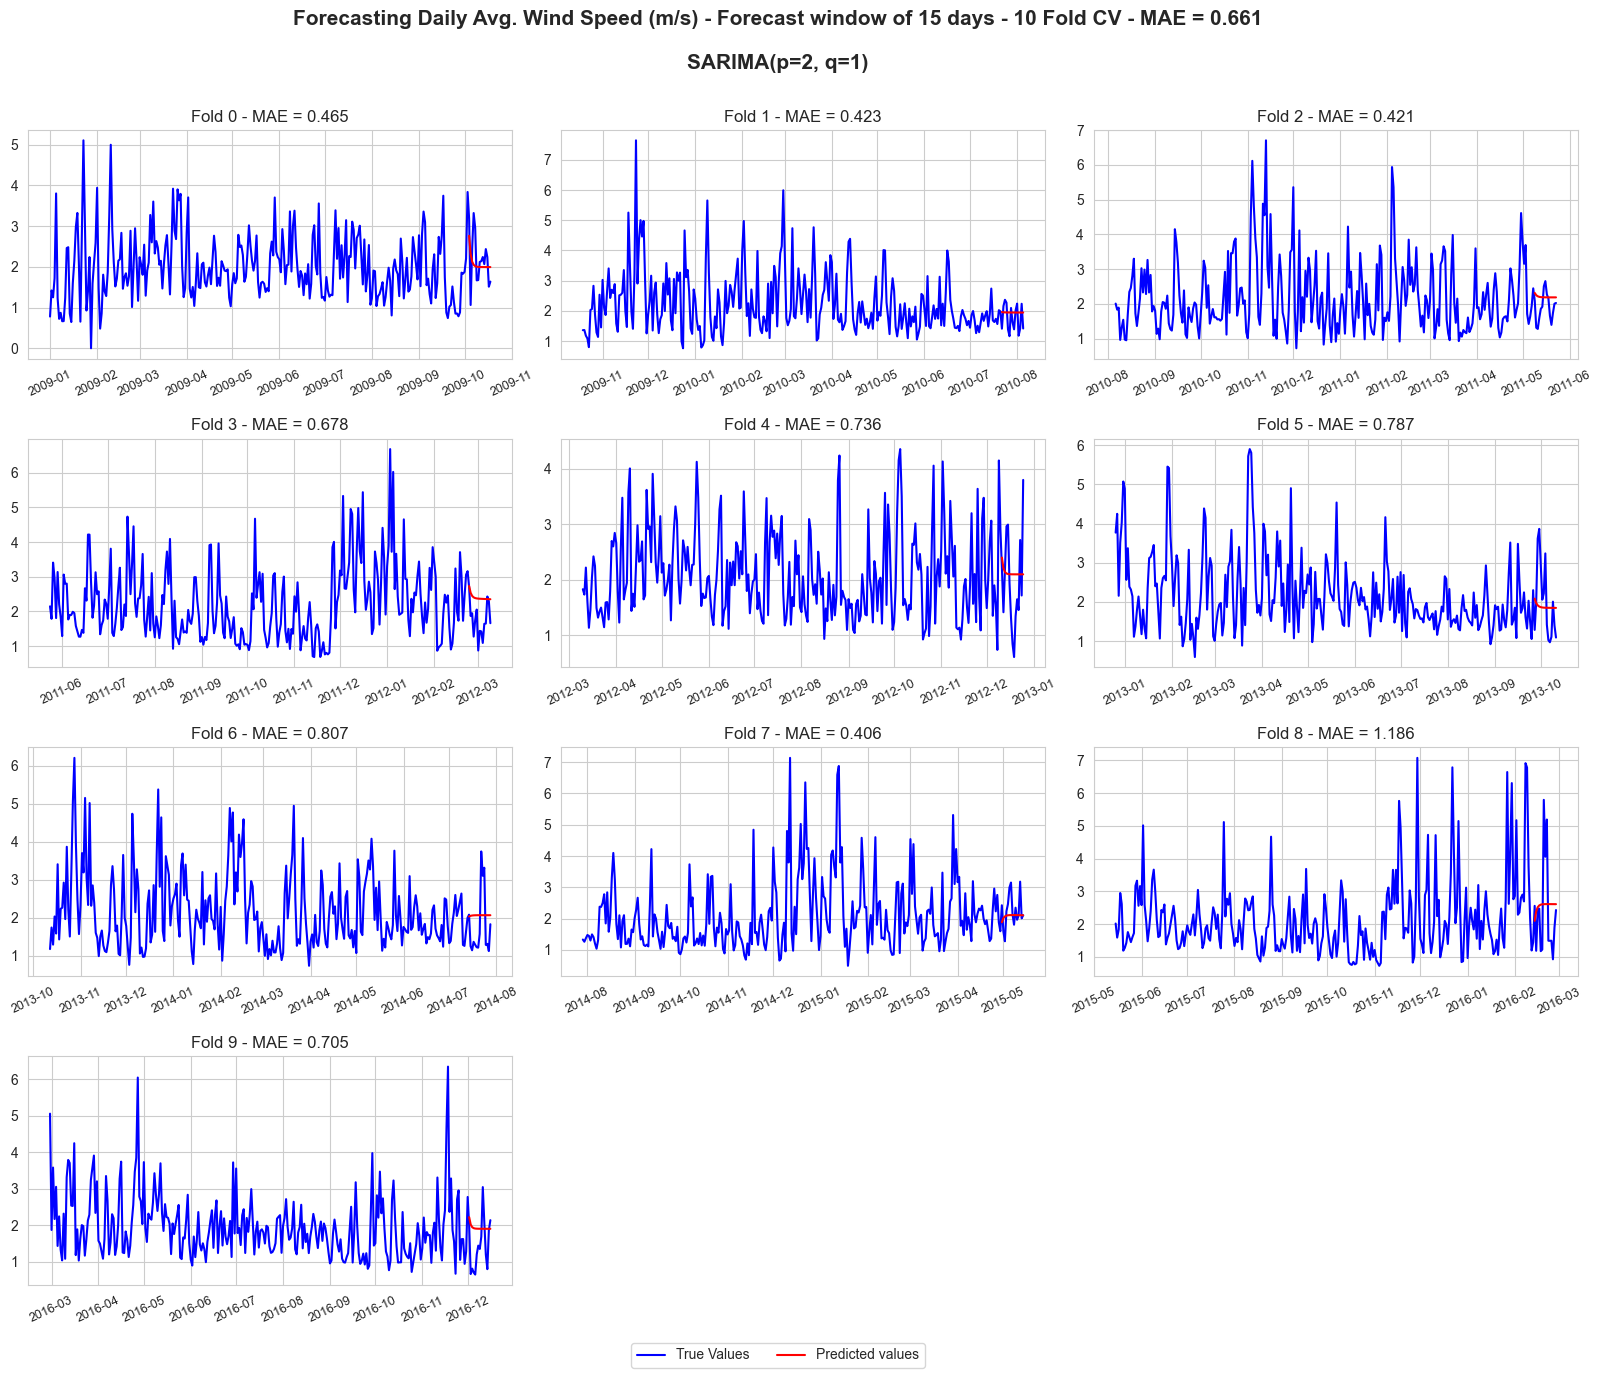

In [85]:
estimator = sarima[series][5]
model_name = str(sarima[series][5])

KFold_time_series_plot(n_cols=3, figsize=(20,15), estimator=estimator, 
                       X=X_train_st[series], y=Y_train_st[series], n_splits=n_splits, test_window=test_window, score=mean_absolute_error, dates=dates,
                       true_color='blue', pred_color='red', marker='', markersize=4,
                       title=f"Forecasting Daily Avg. Wind Speed (m/s) - Forecast window of {forecast_window} days - {n_splits} Fold CV - MAE = {np.round(scores[model_name],3)}\n\n{model_name}",
                       hspace=0.35, wspace=0.1, subtitles_size=12, title_size=15, xticks_rotation=25, 
                       bbox_to_anchor=(0.5,0.05))

- Linear regression with 3 lags

Fold's size: 290. Train size: 275. Test size: 15


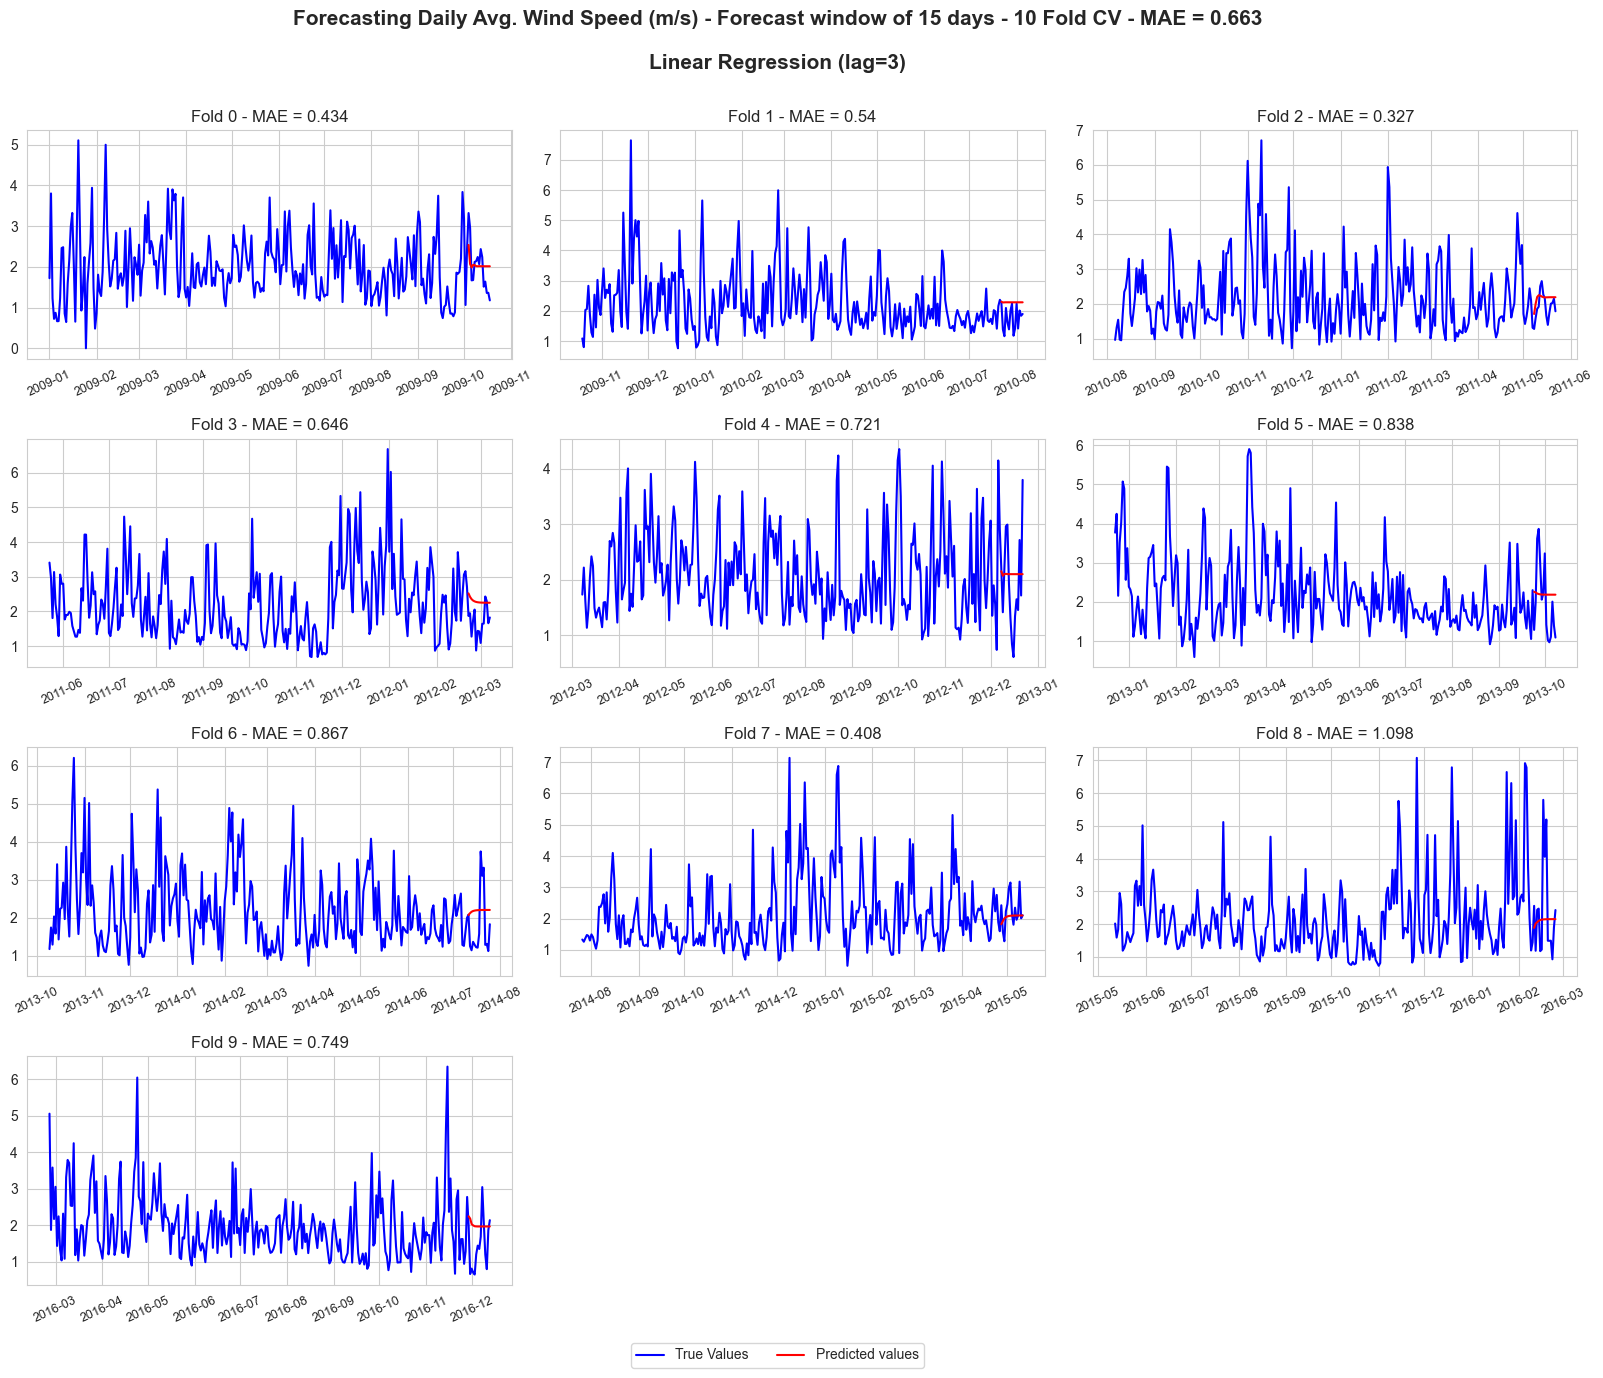

In [82]:
estimator = linear_regression
lag = 3
model_name = f'Linear Regression (lag={lag})'

KFold_time_series_plot(n_cols=3, figsize=(20,15), estimator=estimator,  score=mean_absolute_error,
                       X=X_train_sk[series][lag], y=Y_train_sk[series][lag], n_splits=n_splits, test_window=test_window, dates=dates,
                       true_color='blue', pred_color='red', marker='', markersize=4,
                       title=f"Forecasting Daily Avg. Wind Speed (m/s) - Forecast window of {forecast_window} days - {n_splits} Fold CV - MAE = {np.round(scores[model_name],3)}\n\n{model_name}",
                       hspace=0.35, wspace=0.1, subtitles_size=12, title_size=15, xticks_rotation=25, 
                       bbox_to_anchor=(0.5,0.05))

##### **Estimation of future performance**

We estimate the future performance of the best model according to KFold Cross Validation.

In [83]:
best_model_CV

'SARIMA(p=2, q=1)'

In [84]:
lag = 3
linear_regression.fit(X=X_train_sk[series][lag], y=Y_train_sk[series][lag])
Y_test_hat = linear_regression.forecast(window=test_window)
estimation_future_performance = mean_absolute_error(y_pred=Y_test_hat, y_true=Y_test_sk[series][lag])
estimation_future_performance

0.8715102370962747

### **Conclusions**

- In this project we have look for a good model for forecasting the temperature, humidity and wind speed of an specific region of Germany. We have done that focus on statistical techniques, like the family of models SARIMA, exponential smoothing, KNN and linear regression. 

- We have been focus on the manual SARIMA, that is, in the specification of the parameters of this model in a manual way, by exploring and analyzing the auto correlations of the series and their trend and seasonality. 

- We have also implemented some code oriented to apply the so popular and well developed Machine Learning library `sklearn` to time series. How powerful this could be will be show in the next project with more details. This developments are contained in  `PyTS.py`, and will be improve for the next project.

- In addition, we have analyzed the two already classic ways of comparing models in time series, simple validation and cross validation. And we had reach the conclusion that the second one is a much more reliable option.

- At the end we have obtained three models for forecasting our variables, the ones are not too bad, but can be improved with a more exhaustive search, based on ML model and techniques, as we will see in the next project. So, we consider this project as a first step for a better upcoming project (in term of expected results).